## Projeto_Rossmann

## 0.0. Imports

In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install inflection

  Using cached inflection-0.5.1-py2.py3-none-any.whl (9.5 kB)


In [53]:
!pip install sklearn

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2953 sha256=fa77f7971af199f1b3746c8820af10eb9affadc6ff99c6cffae8dc213e2605a8
  Stored in directory: c:\users\deeww\appdata\local\pip\cache\wheels\1c\2f\26\476423e3abcbdc095c9061b4a385339f4d5c4952c036ef8262
Successfully built sklearn


In [112]:
!pip install tabulate

In [41]:

import math
import numpy  as np
import pandas as pd
import random
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
from scipy                  import stats as ss
from boruta                 import BorutaPy
from matplotlib             import pyplot as plt
from IPython.display        import Image
from IPython.core.display   import HTML

from sklearn.metrics        import mean_absolute_error, mean_squared_error
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import LinearRegression, Lasso
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

ModuleNotFoundError: No module named 'xgboost'

### 0.1. Helper functions

In [34]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y 

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( { 'Model Name': model_name,
                            'MAE': mae,
                            'MAPE': mape,
                            'RMSE': rmse }, index=[0] )

# Função para calcular cramer V
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )
                   
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
                   

In [4]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### 0.2. Loading data

In [5]:
df_sales_raw = pd.read_csv('train.csv', low_memory=False)
df_store_raw = pd.read_csv('store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

## 1.0 Passo 1: Descrição dos dados 

In [6]:
df1 = df_raw.copy()

In [12]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

### 1.1 Rename Columns

In [10]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

#snakecase = lambda x: inflection.underscore(x)

#cols_new = list(map(snakecase, cols_old))

# rename
#df1_columns = cols_new

In [13]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

### 1.2 Data Dimensions

In [14]:
print('Number of Rows {}'.format(df1.shape[0]))
print('Number of Rows {}'.format(df1.shape[1]))

Number of Rows 1017209
Number of Rows 18


### 1.3  Data Types

In [7]:
df1['Date'] = pd.to_datetime(df1['Date'])
df1.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

### 1.4 Check NA

In [16]:
df1.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

### 1.5 Fillout NA

In [8]:
# Método - lógica de negócio
df1['CompetitionDistance'].max()

75860.0

In [18]:
# para ver uma linha aleatória
df1.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
297208,64,1,2014-10-27,8144,692,1,0,0,0,d,c,22560.0,NaN,NaN,1,14.0,2013.0,"Jan,Apr,Jul,Oct"


In [9]:
#math.isnan (para saber os NA)
#CompetitionDistance - distância do competidor mais próximo
# colocando a distância maior do que a distância máxima (para dizer que não tem competidor próximo)
df1['CompetitionDistance'] = df1['CompetitionDistance'].apply (lambda x: 200000.0 if math.isnan(x) else x)

#CompetitionOpenSinceMonth: Mês e ano de abertura de loja competidora mais próxima   
# Se em determinada linha for NA  copia a data daquela linha, data de venda (extrai o mês)
df1['CompetitionOpenSinceMonth'] = df1.apply(lambda x: x['Date'].month if math.isnan(x['CompetitionOpenSinceMonth'])else x['CompetitionOpenSinceMonth'], axis=1)

#CompetitionOpenSinceYear     
df1['CompetitionOpenSinceYear'] = df1.apply(lambda x: x['Date'].year if math.isnan(x['CompetitionOpenSinceYear'])else x['CompetitionOpenSinceYear'], axis=1)

#Promo2SinceWeek (descreve o ano e a semana que a loja participou da promo 2 (zero não está participando, 1 está participando)
# substitui o NA pela data da linha
df1['Promo2SinceWeek'] = df1.apply(lambda x: x['Date'].week if math.isnan(x['Promo2SinceWeek'])else x['Promo2SinceWeek'], axis=1)

#Promo2SinceYear  
df1['Promo2SinceYear'] = df1.apply(lambda x: x['Date'].year if math.isnan(x['Promo2SinceYear'])else x['Promo2SinceYear'], axis=1)

#PromoInterval (descreve quais são os intervalos em que a promo 2 começou, nomeando os meses)  
# criando uma coluna auxiliar: PromoInterval
# Substitui o 1 por janeiro...
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'Mai', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

#SE for NA substitui por zero
df1['PromoInterval'].fillna(0, inplace=True)

df1['month_map'] = df1['Date'].dt.month.map(month_map)  ## coluna por mês

## Condições: Promointerval
# Promointerval: split para uma lista: se month_map retornar 1 significa que participou da promoção estendida, senão resulta zero 
# utiliza axis = 1 para especificar a coluna (temos mais de uma)
# Cria a coluna is_promo
df1['is_promo'] = df1[['PromoInterval', 'month_map']].apply(lambda x: 0 if x['PromoInterval'] == 0 else 1 if x['month_map'] in x['PromoInterval'].split(',') else 0, axis=1)

In [20]:
df1.head().T

,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,1,1,1,1,1
StoreType,c,a,a,c,a


### 1.6 Change Types

In [21]:
df1.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
month_map                            object
is_promo                              int64
dtype: object

In [10]:

df1['CompetitionOpenSinceMonth'] = df1['CompetitionOpenSinceMonth'].astype(int)
df1['CompetitionOpenSinceYear'] = df1['CompetitionOpenSinceYear'].astype(int)

df1['Promo2SinceWeek'] = df1['Promo2SinceWeek'].astype(int)
df1['Promo2SinceYear'] = df1['Promo2SinceYear'].astype(int)


### 1.7. Descriptive Statistical

In [28]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numeric Attributes

In [24]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion (quão próximo ou longe da média): std, min, max, range, skew, kurtosis 
# skew (deformação em relação a curva normal)
# kusrtosis (concentração de dados)
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max )).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2,d1, d5, d6]).T.reset_index()
m

# Rename columns
m.columns = ['atributtes', 'min', 'max', 'range','mean', 'median','std','skew','kurtosis']

In [25]:
m

,atributtes,min,max,range,mean,median,std,skew,kurtosis
0,Store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,DayOfWeek,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,Sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,Customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,Open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,Promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,SchoolHoliday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,CompetitionDistance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,Promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.154080,0.0,0.361026,1.916318,1.672276


C:\Users\deeww\AppData\Local\Temp\ipykernel_8348\2443791083.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['Sales'])


<AxesSubplot: xlabel='Sales', ylabel='Density'>

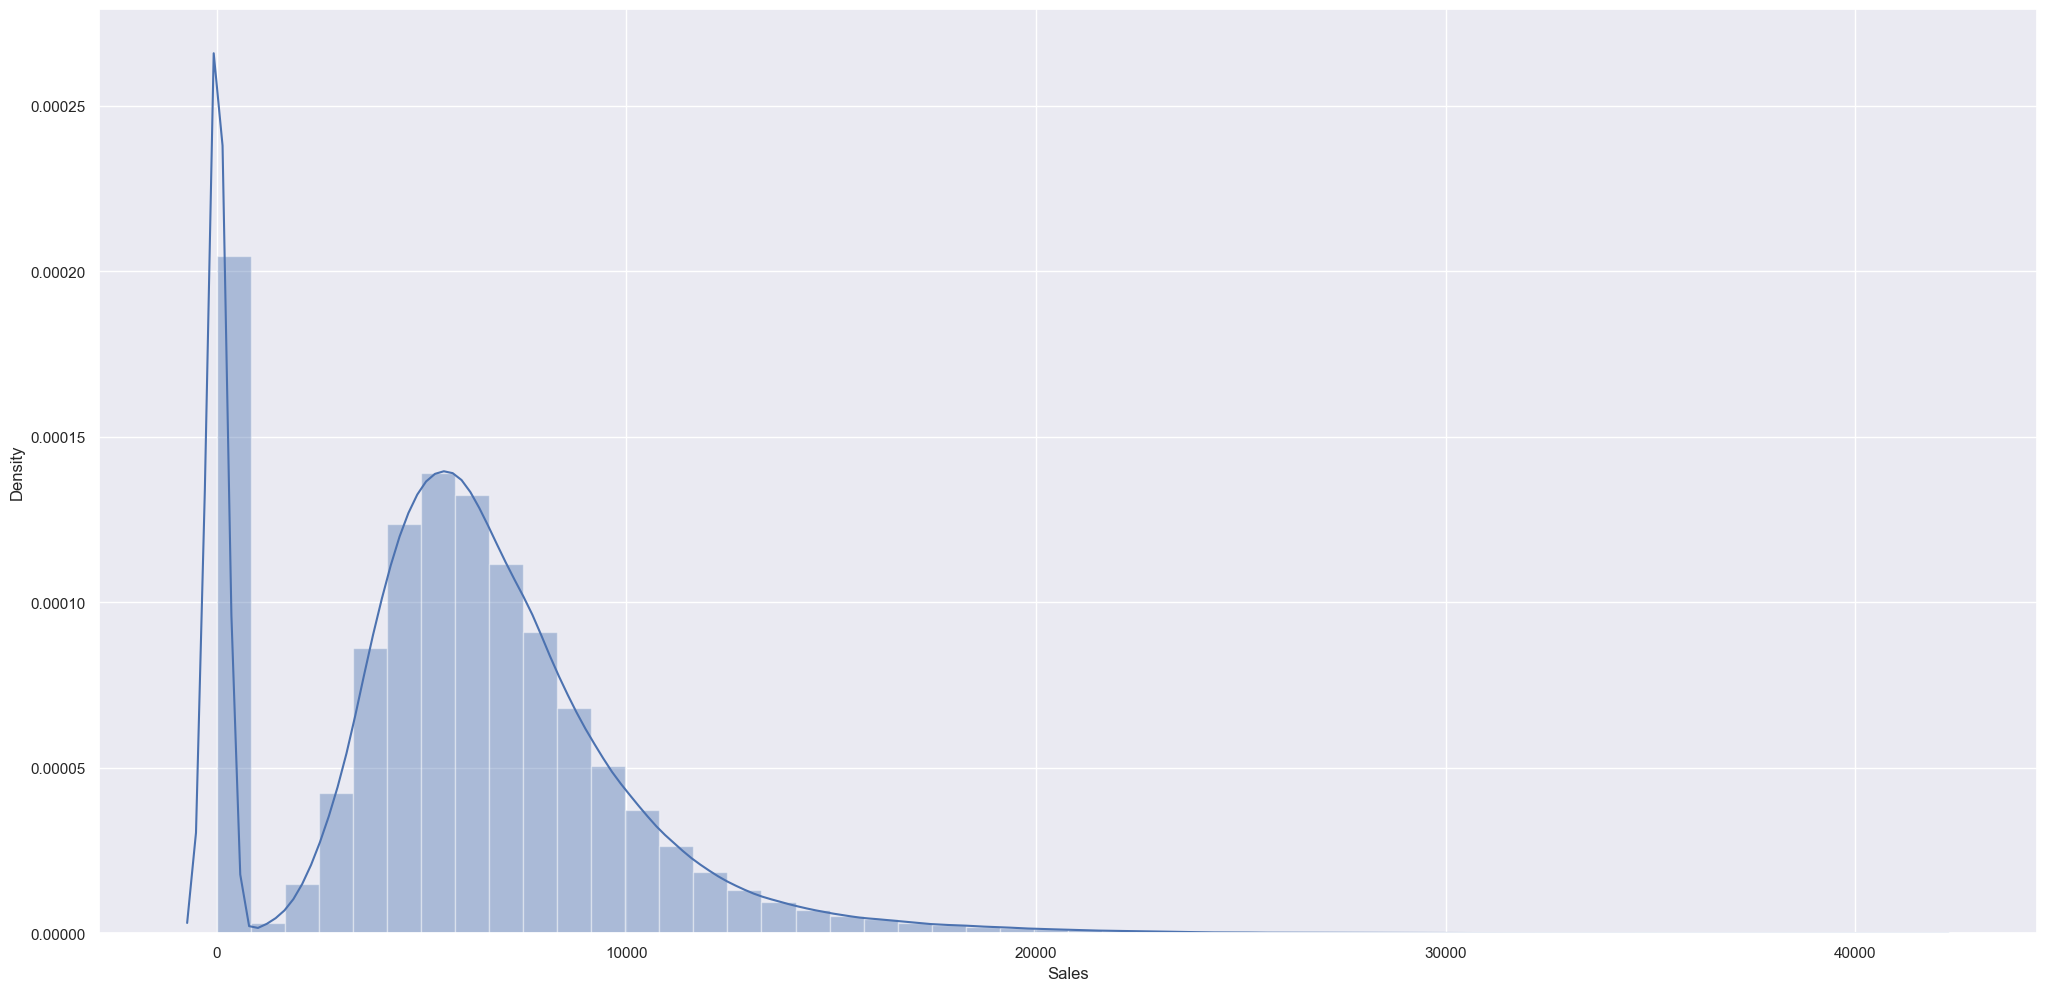

In [26]:
sns.distplot(df1['Sales'])
## Curva próxima da normal (media e mediana parecidas), como  akurtosis é posítiva, existe um deslocamento para a esquerda

C:\Users\deeww\AppData\Local\Temp\ipykernel_8348\2074552752.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['CompetitionDistance'])


<AxesSubplot: xlabel='CompetitionDistance', ylabel='Density'>

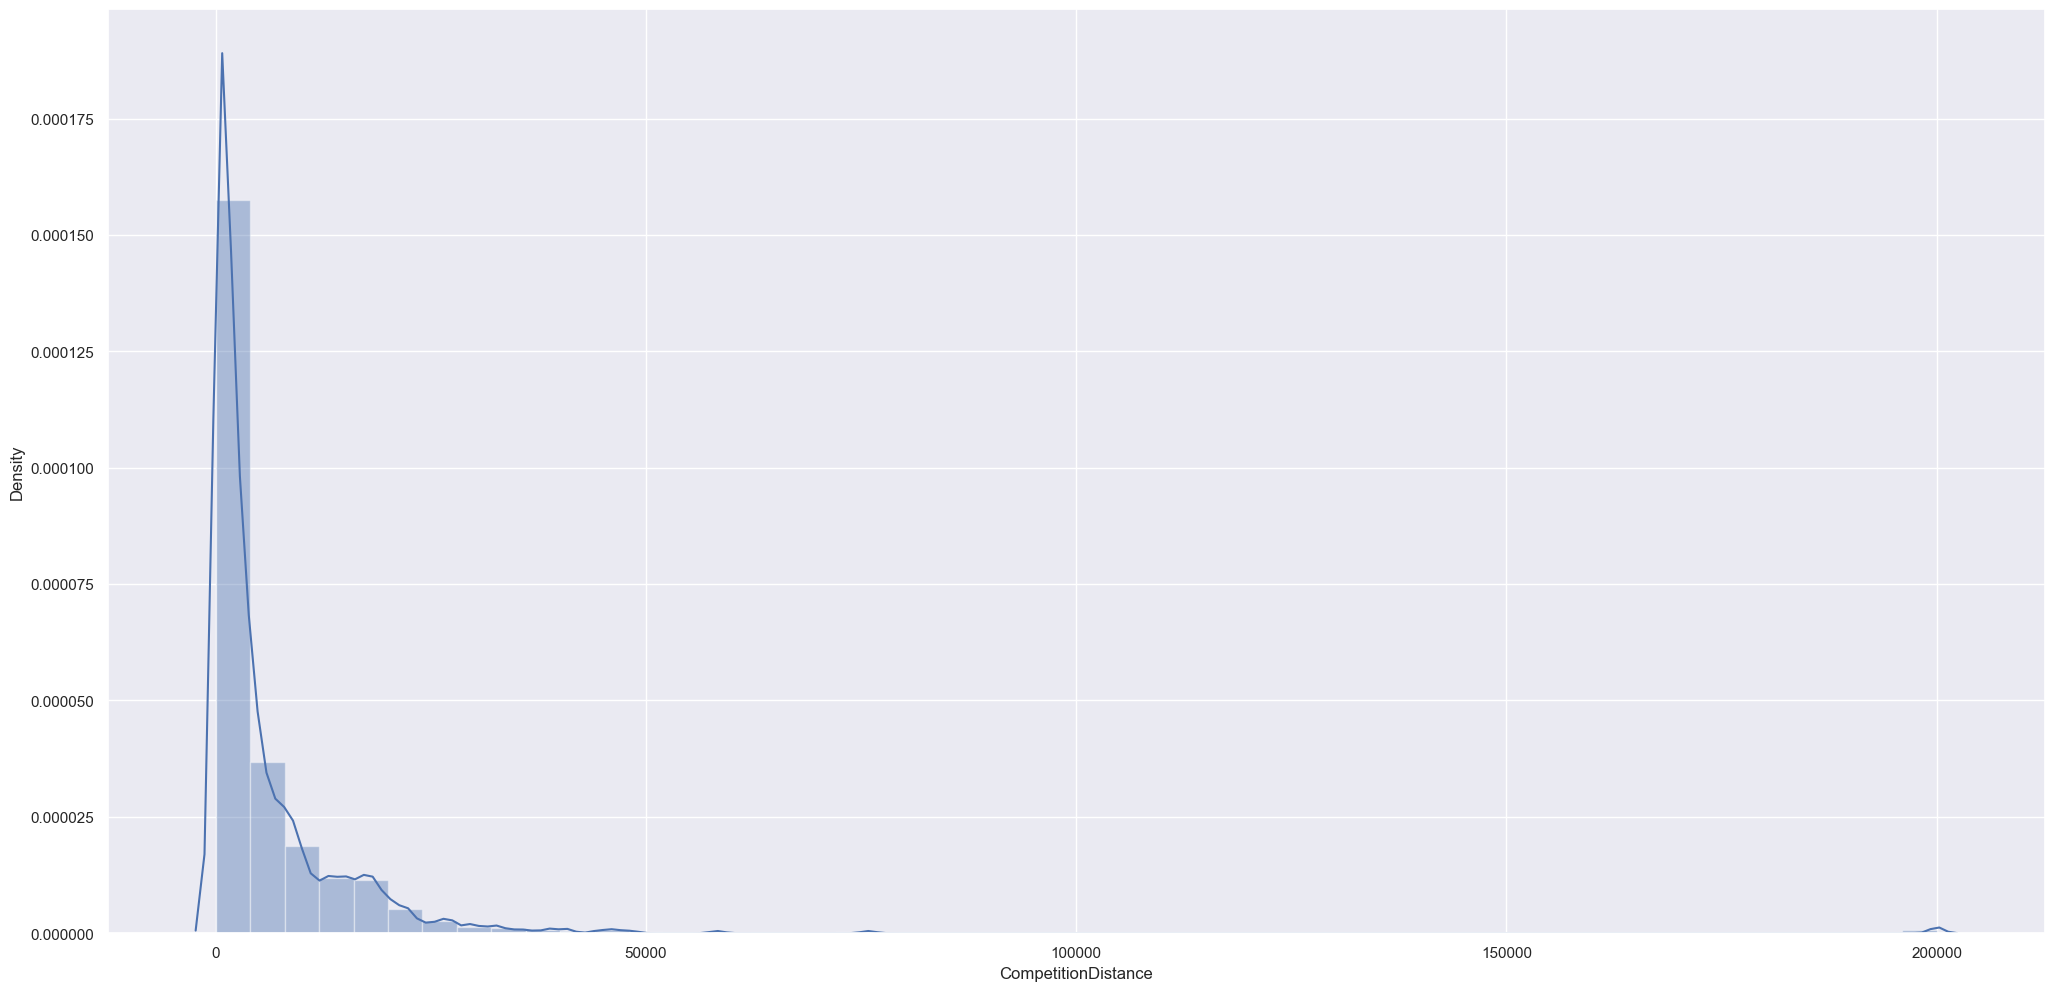

In [27]:
sns.distplot(df1['CompetitionDistance'])
# Curva com um pico muito alto - poison: distância entre os competidores próxima do zero (alta concentração - kurtosis muito positiva)

C:\Users\deeww\AppData\Local\Temp\ipykernel_8348\3548126039.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['Customers'])


<AxesSubplot: xlabel='Customers', ylabel='Density'>

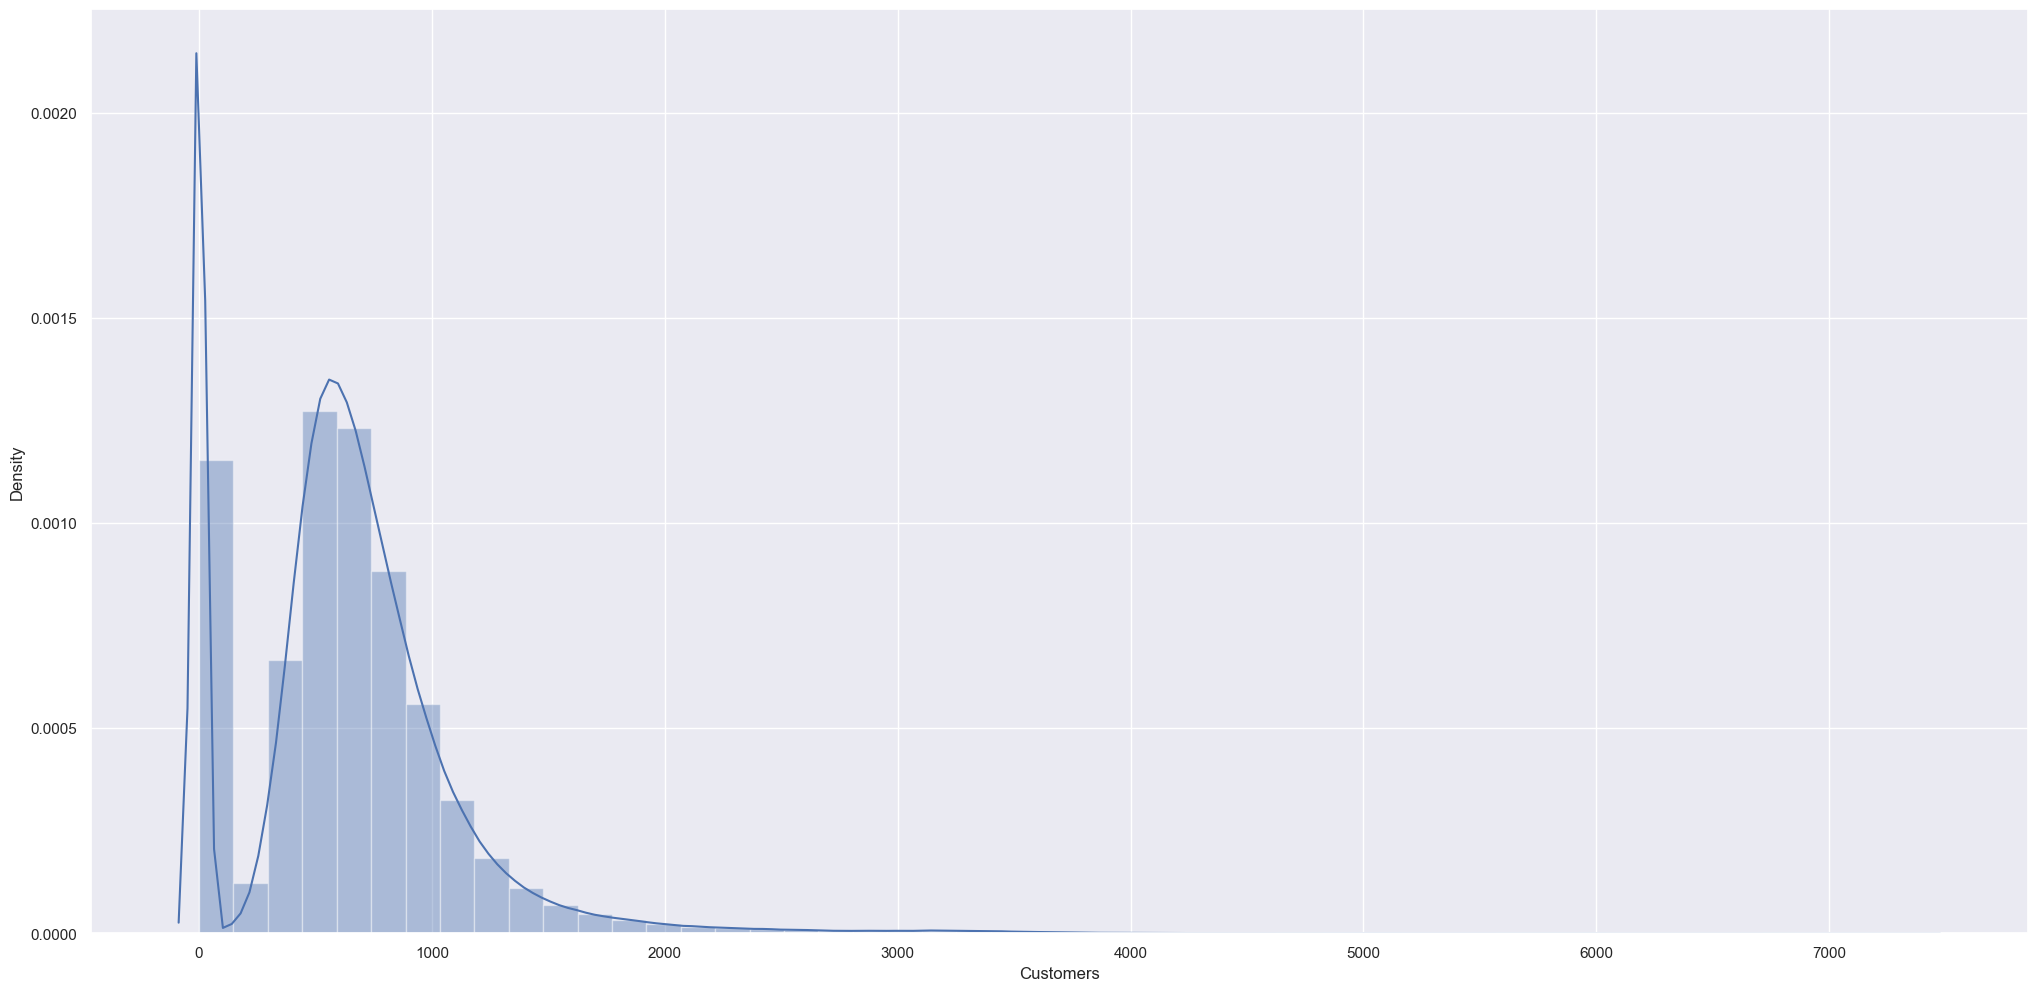

In [28]:
sns.distplot(df1['Customers'])
# Pessoas circulando na loja

### 1.7.2 Categorical attributes

In [32]:
cat_attributes.apply(lambda x: x.unique().shape[0])

StateHoliday                  4
StoreType                     4
Assortment                    3
CompetitionOpenSinceMonth    12
CompetitionOpenSinceYear     23
Promo2SinceWeek              52
Promo2SinceYear               7
PromoInterval                 4
month_map                    12
dtype: int64

In [11]:
df1.groupby(['StateHoliday']).size()

StateHoliday
0    986159
a     20260
b      6690
c      4100
dtype: int64

<AxesSubplot: xlabel='Assortment', ylabel='Sales'>

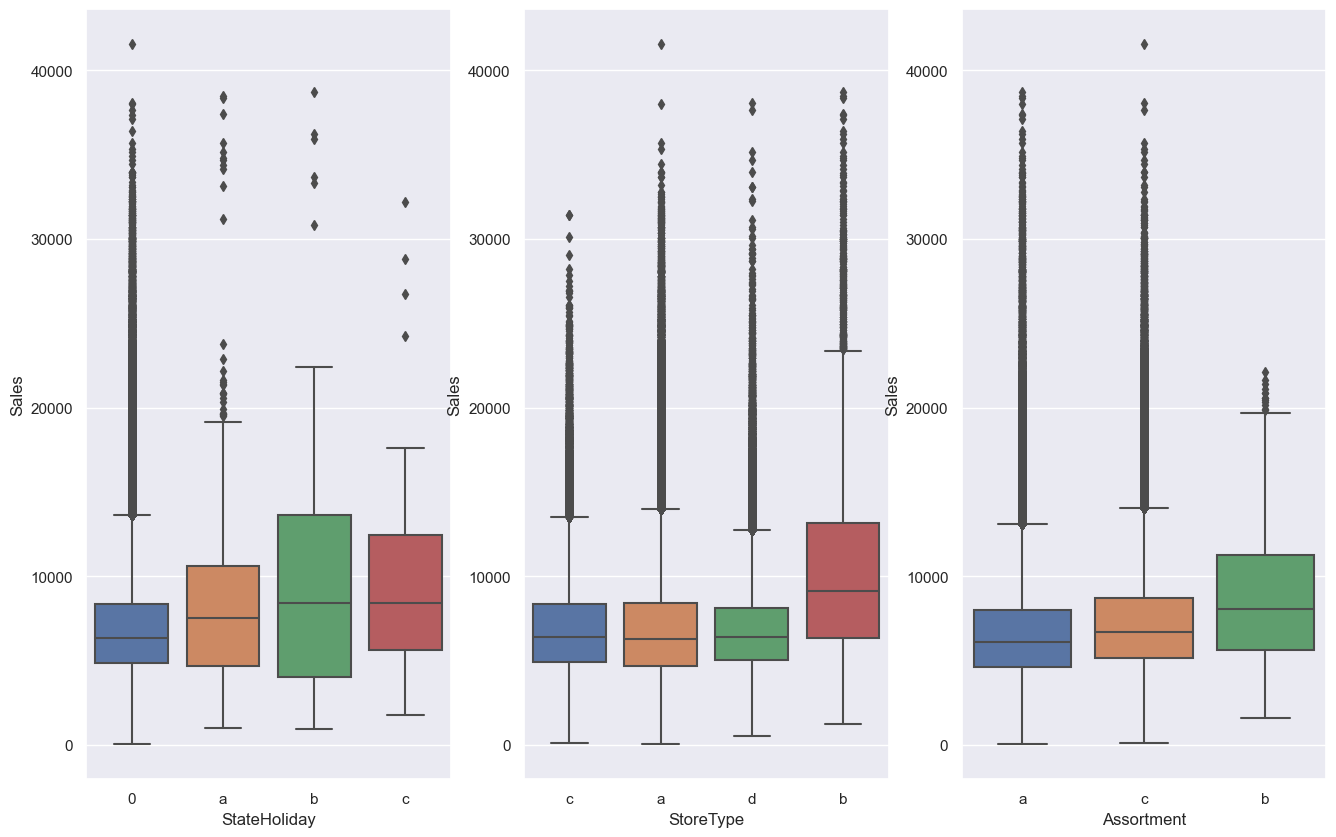

In [12]:
aux1 = df1[(df1['StateHoliday']!= 0) & (df1['Sales']>0)] # Retira as vendas = zero (loja estava fechada)

plt.figure(figsize =(16,10))
plt.subplot(1,3,1)
sns.boxplot( x='StateHoliday', y='Sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot( x='StoreType', y='Sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot( x='Assortment', y='Sales', data=aux1)

In [35]:
### outlier é 3x o valor do desvio-padrão
### StateHoliday: Feriado 
# O feriado b está em equilíbrio nos quartis, o feriado c apresenta uma alta nas vendas acima da mediana
# Storetype: tipo de loja - a loja b possui vendas acima da média e também tem muito mais outliers, na c a mediana é alta, mas tem uma concentração próxima da mediana
# Assortment (sortimento/variedade): maior parte dos mix de produtos estão no mix b. a e c tem mais outliers

## 2.0 Passo 2: Feature Engineering

In [13]:
# Cópia do DataFrame
df2 = df1.copy()

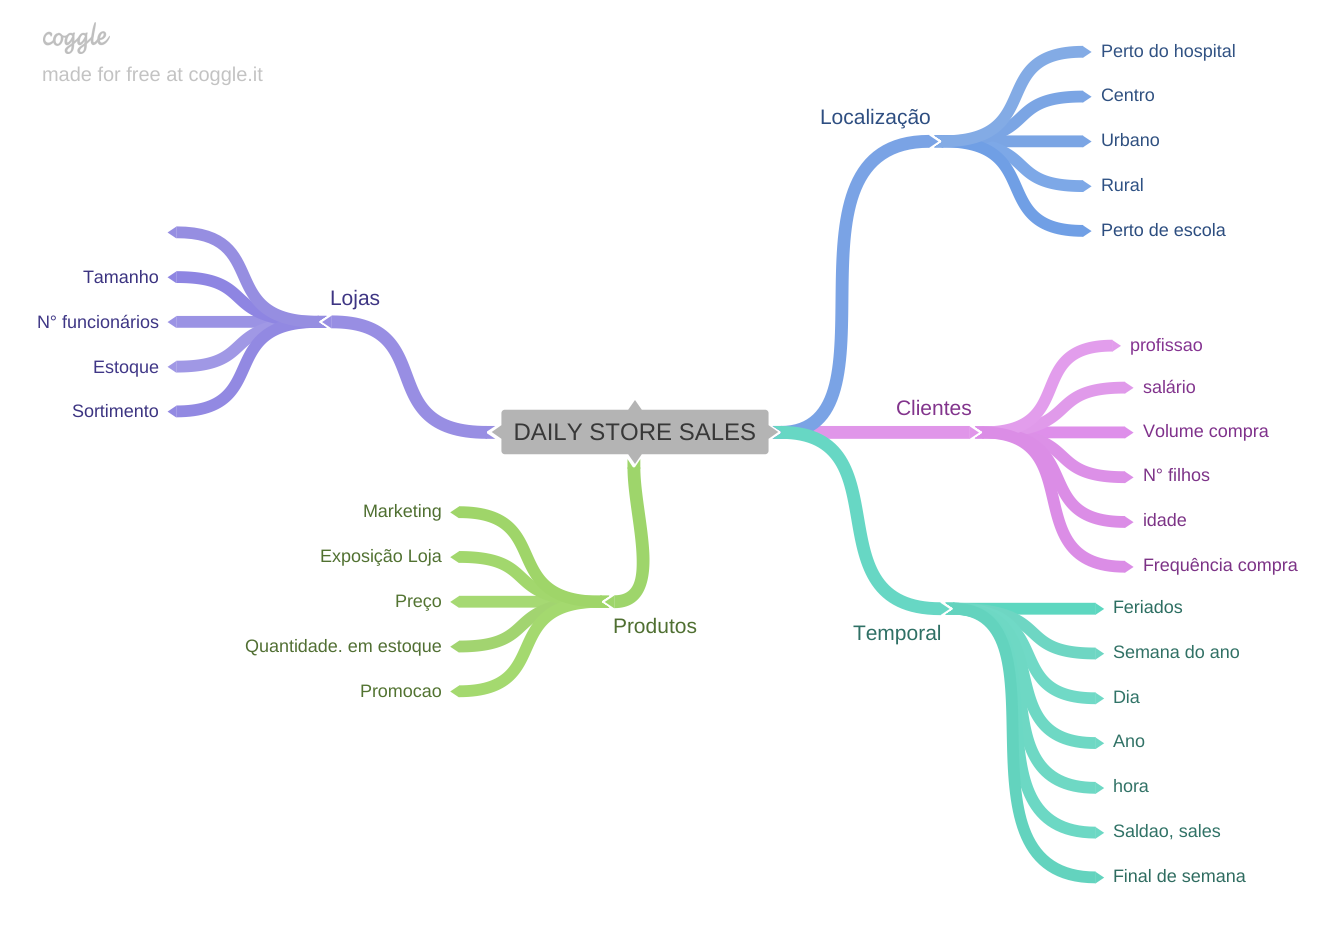

In [37]:
Image('img/MindMap_hipoteses.png')

### 2.1 Criação de Hipóteses

#### 2.1.1 Hipóteses relacionadas às lojas

**1.** Lojas com quadro de funcionários maior deveriam vender mais

**2.** Lojas com estoque maior deveriam vender mais

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com sortimento maior deveriam vender mais

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores há mais tempo deveriam vender mais


#### 2.1.2 Hipóteses relacionadas aos Produtos

**1.** Lojas que investem mais em marketing deveriam vender mais

**2.** Lojas que expoem mais os produtos na vitrine deveriam vender mais

**3.** Lojas que tem preços menores nos produtos deveriam vender mais

**4.** Lojas que tem preços menores por mais tempo nos produtos deveriam vender menos

**5.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais

**7.** Lojas com mais dias de promoção deveriam vender mais

**8.** Lojas mais promoções consecutivas deveriam vender mais

#### 2.1.3 Hipóteses relacionadas ao tempo

**1.** Lojas abertas durante o feriado de natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos nos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares



### 2.2 Lista final de Hipóteses (Priorização)

**1.** Lojas com sortimento maior deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores há mais tempo deveriam vender mais


**4.** Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas mais promoções consecutivas deveriam vender mais


**7.** Lojas abertas durante o feriado de natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês

**11.** Lojas deveriam vender menos nos finais de semana

**12.** Lojas deveriam vender menos durante os feriados escolares

### 2.3 Feature engineering

In [38]:
df2.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'month_map', 'is_promo'],
      dtype='object')

In [39]:
df2.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth             int32
CompetitionOpenSinceYear              int32
Promo2                                int64
Promo2SinceWeek                       int32
Promo2SinceYear                       int32
PromoInterval                        object
month_map                            object
is_promo                              int64
dtype: object

In [40]:
df2.isna().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
month_map                    0
is_promo                     0
dtype: int64

In [14]:
df2.groupby(['StateHoliday']).size()

StateHoliday
0    986159
a     20260
b      6690
c      4100
dtype: int64

In [15]:
## Derivando features da data: novas colunas ###

# year
df2['year'] = df2['Date'].dt.year

# month
df2['month'] = df2['Date'].dt.month

# day
df2['day'] = df2['Date'].dt.day

# week of year
df2['week_of_year'] = df2['Date'].dt.weekofyear

# year week
df2['year_week'] = df2['Date'].dt.strftime( '%Y-%W' )

# competition since (Quanto tempo tem desde que a competição começou): granularidade 30 = mês

df2['CompetitionSince'] = df2.apply (lambda x: datetime.datetime( year=x['CompetitionOpenSinceYear'], month=x['CompetitionOpenSinceMonth'], day=1), axis=1)
df2['CompettionTimeMonth'] = ((df2['Date'] - df2['CompetitionSince']) /30).apply(lambda x: x.days).astype(int)

# nova coluna: promo since (Quanto tempo tem a promoção): ano e semana, tem que modificar para mês
# Tem que transformar em string para fazer o join; converte para data para poder fazer a subtração
df2['promo_since'] = df2['Promo2SinceYear'].astype(str) + '-' + df2['Promo2SinceWeek'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
# nova coluna: promo_time_week: tempo que a promoção está ativa em semanas
df2['promo_time_week'] = ((df2['Date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment: trocando os níveis a, b, c por basic, extra, extended
df2['Assortment'] = df2['Assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday: trocando a,b,c por Tipos de feriados: Public holiday, Easter holiday, Christmas
df2['StateHoliday'] = df2['StateHoliday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

C:\Users\deeww\AppData\Local\Temp\ipykernel_17960\919734732.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['Date'].dt.weekofyear


In [16]:
df2.groupby(['StateHoliday']).size()

StateHoliday
christmas           4100
easter_holiday      6690
public_holiday     20260
regular_day       986159
dtype: int64

In [44]:
df2.head().T

,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,regular_day,regular_day,regular_day,regular_day,regular_day
SchoolHoliday,1,1,1,1,1
StoreType,c,a,a,c,a


## 3.0 Passo 3 - Filtragem de variáveis

In [17]:
df3 = df2.copy()

In [93]:
df3.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,month_map,is_promo,Month,Day,week_of_year,year_week,CompetitionSince,CompettionTimeMonth,promo_since,promo_time_week,year,month,day
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,extended,1270.0,9,2008,0,31,2015,0,Jul,0,7,31,31,2015-30,2008-09-01,84,2015-07-27,0,2015,7,31
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,extended,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,7,31,31,2015-30,2007-11-01,94,2010-03-22,279,2015,7,31
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,extended,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,7,31,31,2015-30,2006-12-01,105,2011-03-28,226,2015,7,31
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,7,31,31,2015-30,2009-09-01,71,2015-07-27,0,2015,7,31
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,extended,29910.0,4,2015,0,31,2015,0,Jul,0,7,31,31,2015-30,2015-04-01,4,2015-07-27,0,2015,7,31


### 3.1 Filtragem das linhas

In [47]:
df3.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'month_map', 'is_promo', 'Month',
       'Day', 'week_of_year', 'year_week', 'CompetitionSince',
       'CompettionTimeMonth', 'promo_since', 'promo_time_week'],
      dtype='object')

In [18]:
df3 = df3[(df3['Open'] != 0) & (df3['Sales'] >0)]


### 3.2 Seleção das colunas

In [19]:
cols_drop = ['Customers', 'Open', 'PromoInterval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

## 4.0 EDA - Exploração e Análise de Dados

In [20]:
df4 = df3.copy()

In [97]:
### 4.1 Análise UNIVARIADA

#### 4.1.1 Response Variable 

C:\Users\deeww\AppData\Local\Temp\ipykernel_8348\773600024.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['Sales'],kde=False)


<AxesSubplot: xlabel='Sales'>

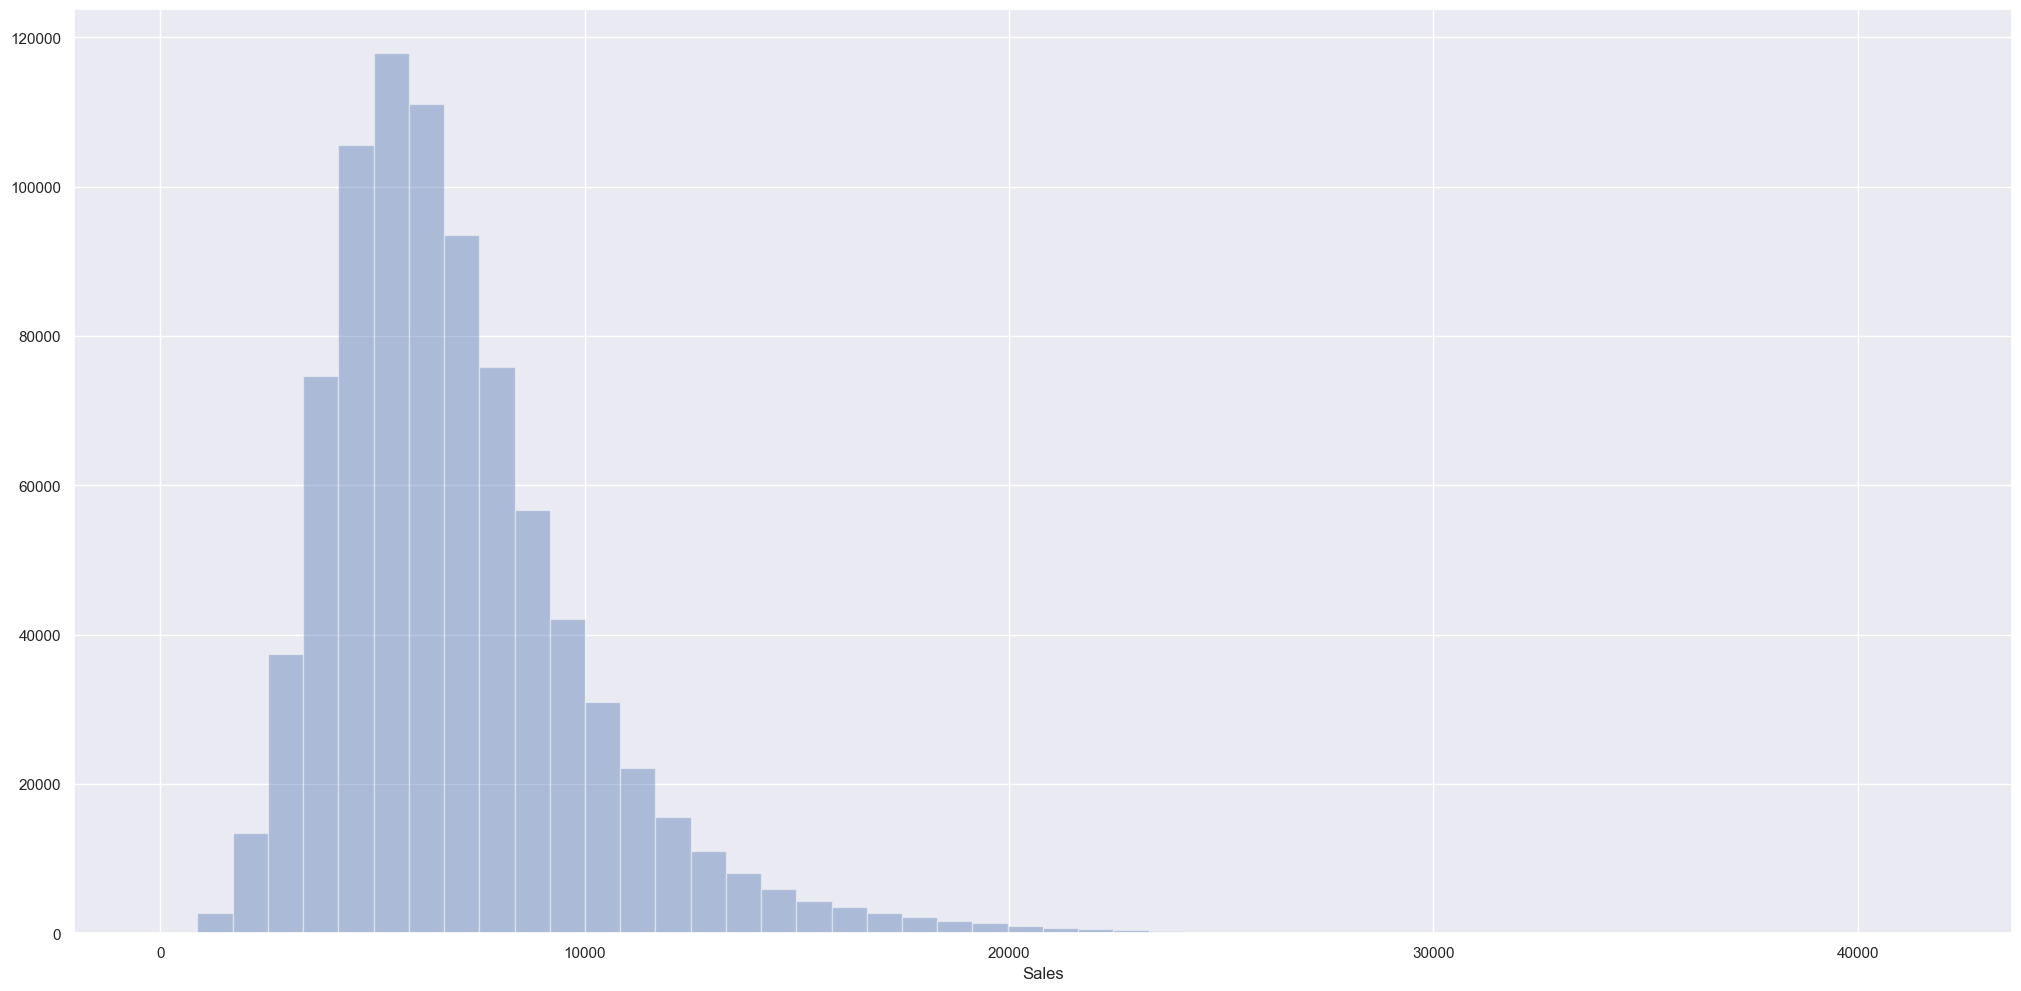

In [52]:
# Gráfico da variável resposta
sns.distplot(df4['Sales'],kde=False)
# Próxima de uma curva normal (mas não é), porque não tem um centro: possui uma kurtose (cauda), skew para esquerda (positiva)

#### 4.1.2 Numerical Variable

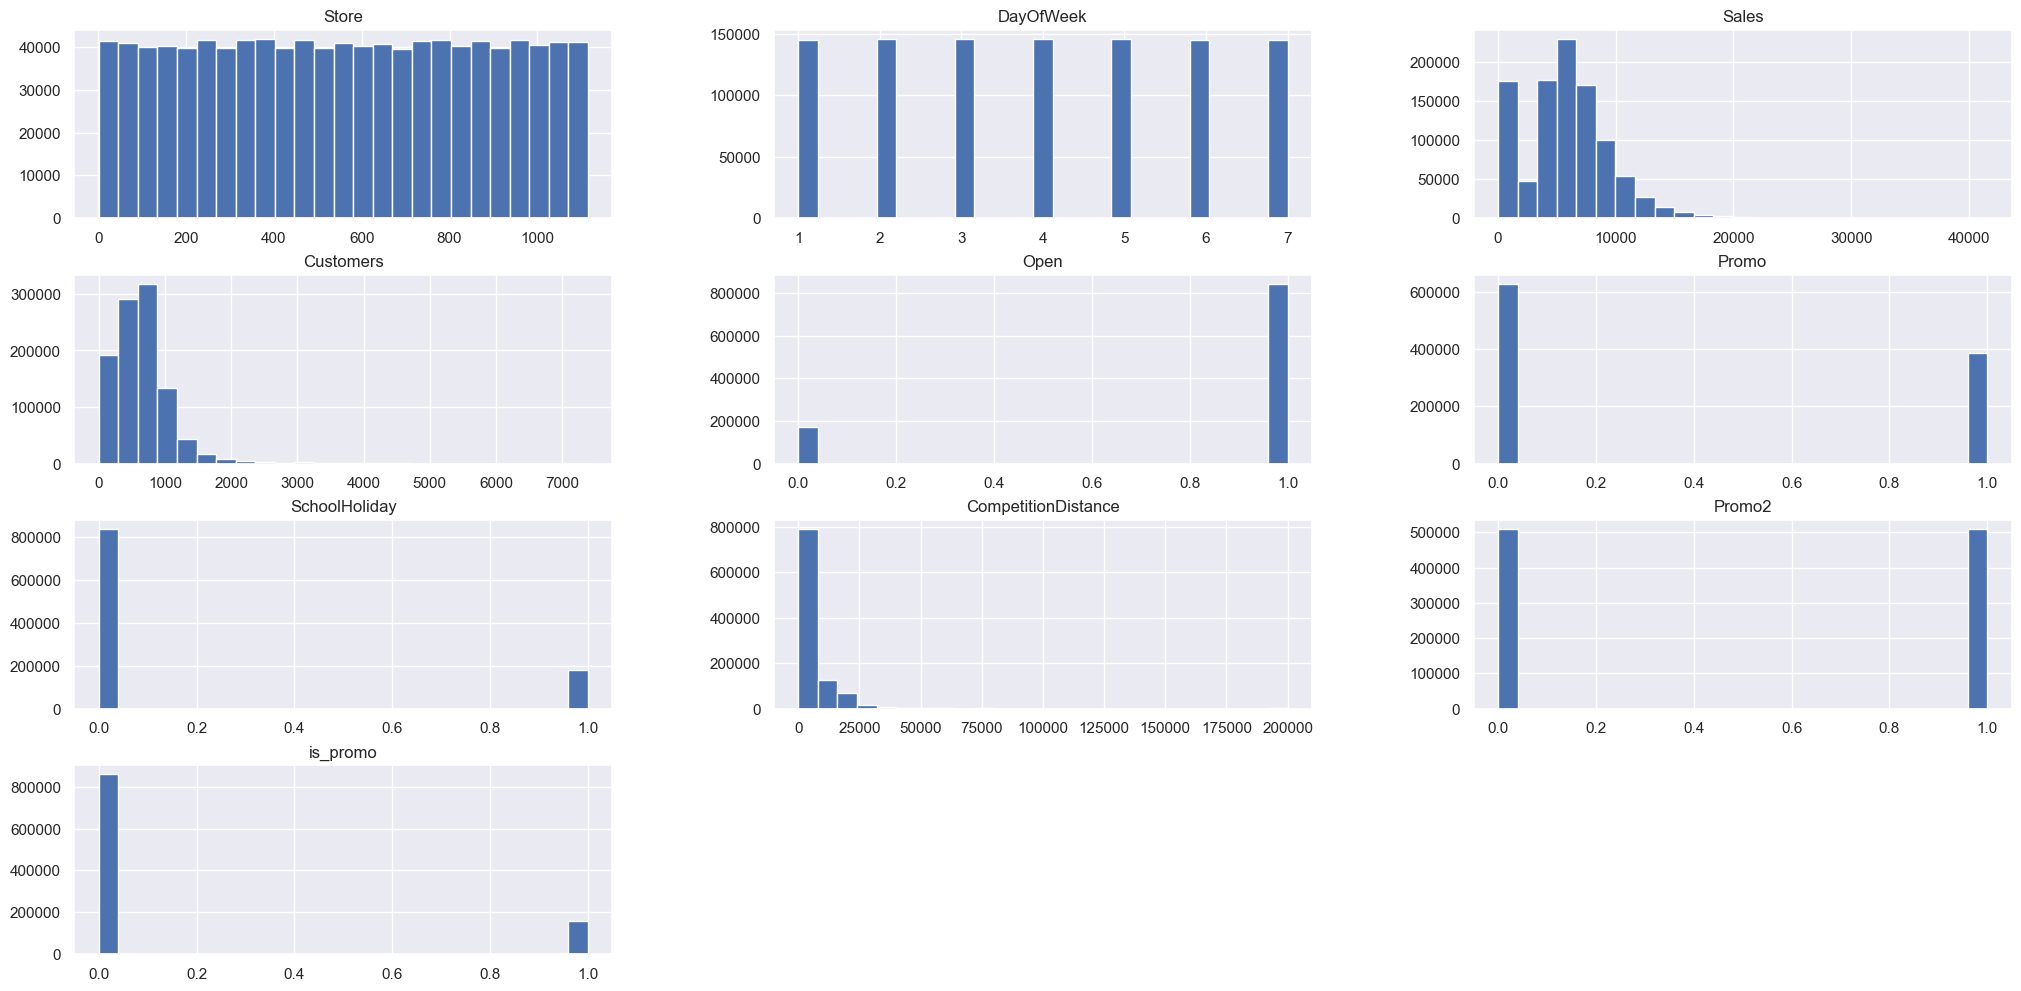

In [29]:
num_attributes.hist(bins=25);


# Todos os competidores estão próximos (distância menor)
# competiition_opne_since_month: demonstra um comportamento
# Day_of_week não tem diferença entre os dias de vendas (não é boa para o modelo)
# ver de novo aula 12 modulo 04

#### 4.1.3 Categorical Variable

In [54]:
df4.groupby(['StateHoliday']).size()

StateHoliday
christmas             71
easter_holiday       145
public_holiday       694
regular_day       843428
dtype: int64

In [55]:
df4.shape

(844338, 24)

In [56]:
df4.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth             int32
CompetitionOpenSinceYear              int32
Promo2                                int64
Promo2SinceWeek                       int32
Promo2SinceYear                       int32
is_promo                              int64
Month                                 int64
Day                                   int64
week_of_year                          int64
year_week                            object
CompetitionSince             datetime64[ns]
CompettionTimeMonth                   int32
promo_since                  dat

<AxesSubplot: xlabel='Sales', ylabel='Density'>

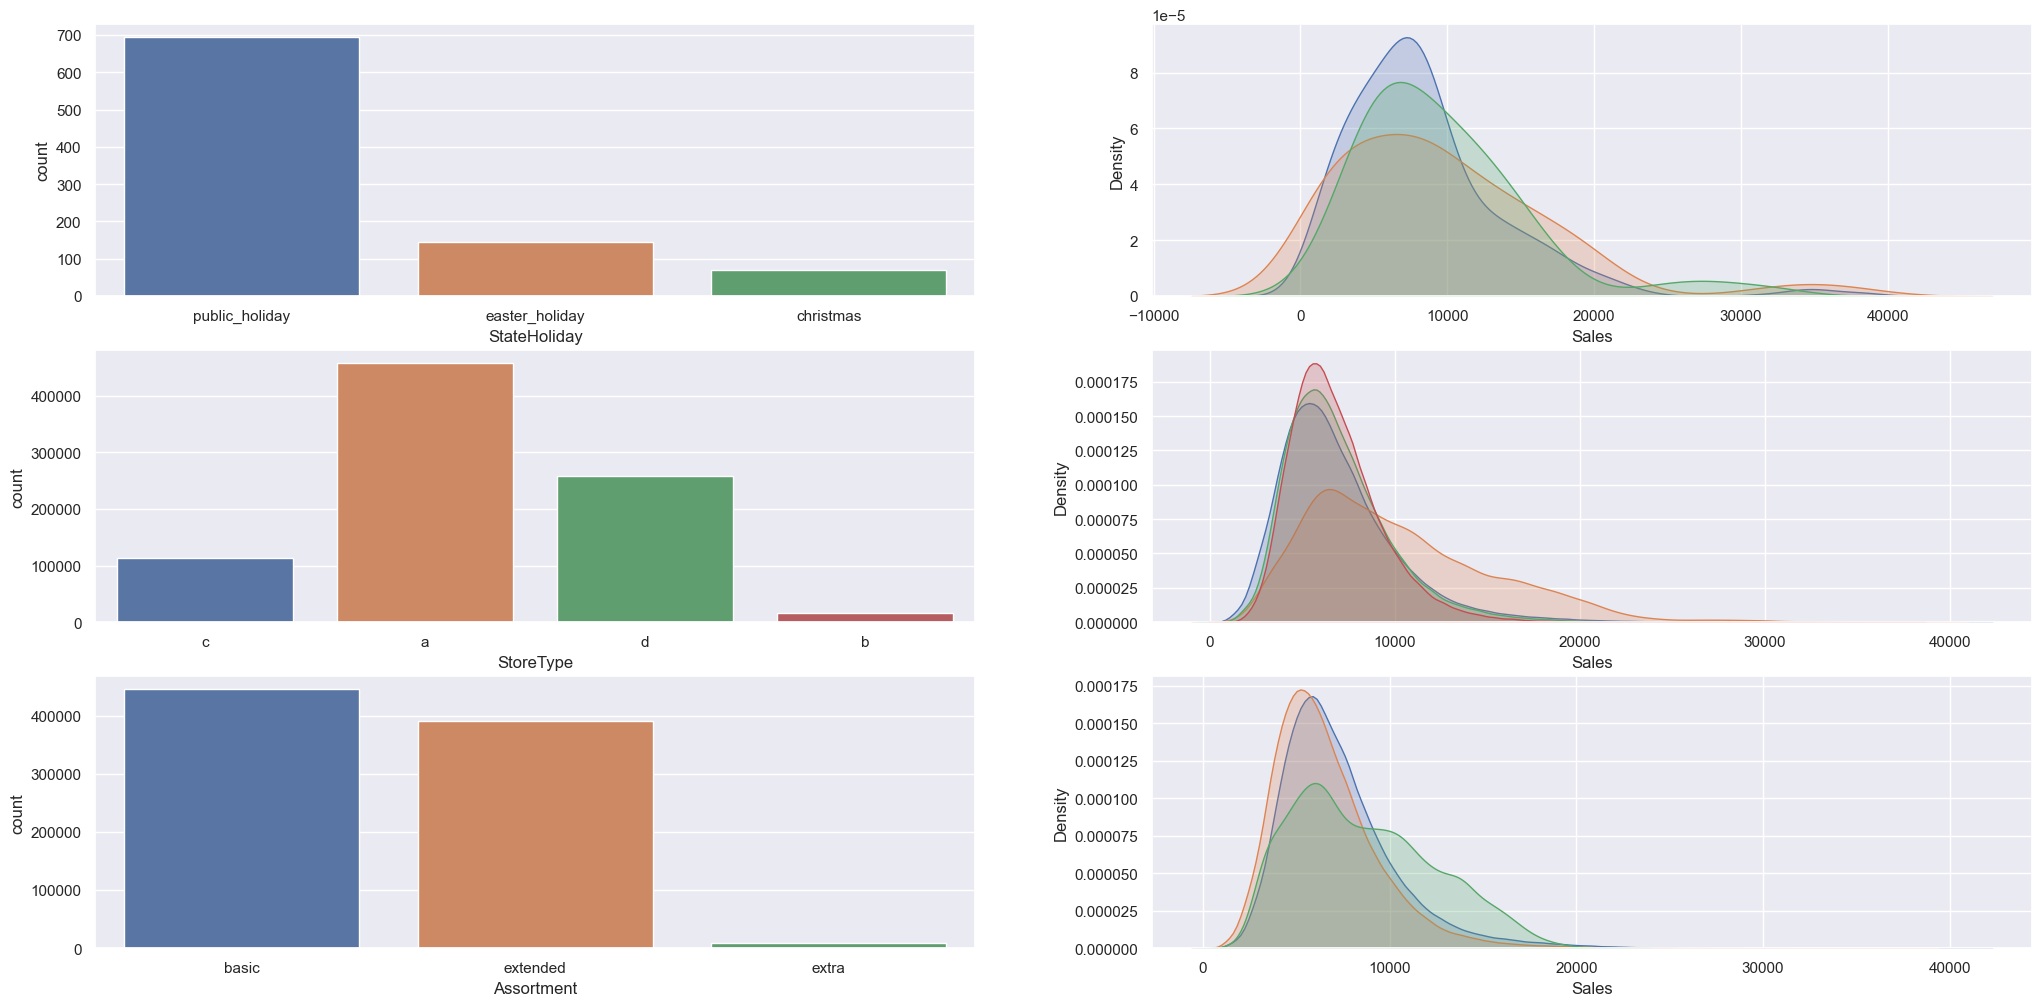

In [21]:
# contar quantas linhas tenho dentro das variáveis categóricas 

# StateHoliday
plt.subplot( 3,2,1 )
a = df4[df4['StateHoliday'] != 'regular_day']
sns.countplot(x = a['StateHoliday'] )
#
plt.subplot( 3,2,2 )
sns.kdeplot(df4[df4['StateHoliday'] == 'public_holiday']['Sales'], label = 'public_holiday', fill = True )
sns.kdeplot(df4[df4['StateHoliday'] == 'easter_holiday']['Sales'], label = 'easter_holiday', fill = True )
sns.kdeplot(df4[df4['StateHoliday'] == 'christmas']['Sales'], label = 'christmas', fill = True )
#
# StoreType
plt.subplot( 3,2,3 )
sns.countplot(x = df4['StoreType'])

plt.subplot( 3,2,4 )
sns.kdeplot(df4[df4['StoreType'] == 'a']['Sales'], label = 'a', fill = True )
sns.kdeplot(df4[df4['StoreType'] == 'b']['Sales'], label = 'b', fill = True )
sns.kdeplot(df4[df4['StoreType'] == 'c']['Sales'], label = 'c', fill = True )
sns.kdeplot(df4[df4['StoreType'] == 'd']['Sales'], label = 'd', fill = True )
#
## Assortment
plt.subplot( 3,2,5 )
sns.countplot(x = df4['Assortment'])
#
plt.subplot( 3,2,6 )
sns.kdeplot(df4[df4['Assortment'] == 'extended']['Sales'], label = 'extended', fill = True )
sns.kdeplot(df4[df4['Assortment'] == 'basic']['Sales'], label = 'basic', fill = True )
sns.kdeplot(df4[df4['Assortment'] == 'extra']['Sales'], label = 'extra', fill = True )


### 4.2 Análise BIVARIADA

### H1. Lojas com MAIOR sortimento vendem MAIS
###### FALSA -> Lojas com MAIOR sortimento vendem menos

In [60]:
df4.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'is_promo', 'Month', 'Day',
       'week_of_year', 'year_week', 'CompetitionSince', 'CompettionTimeMonth',
       'promo_since', 'promo_time_week'],
      dtype='object')

<AxesSubplot: xlabel='year_week'>

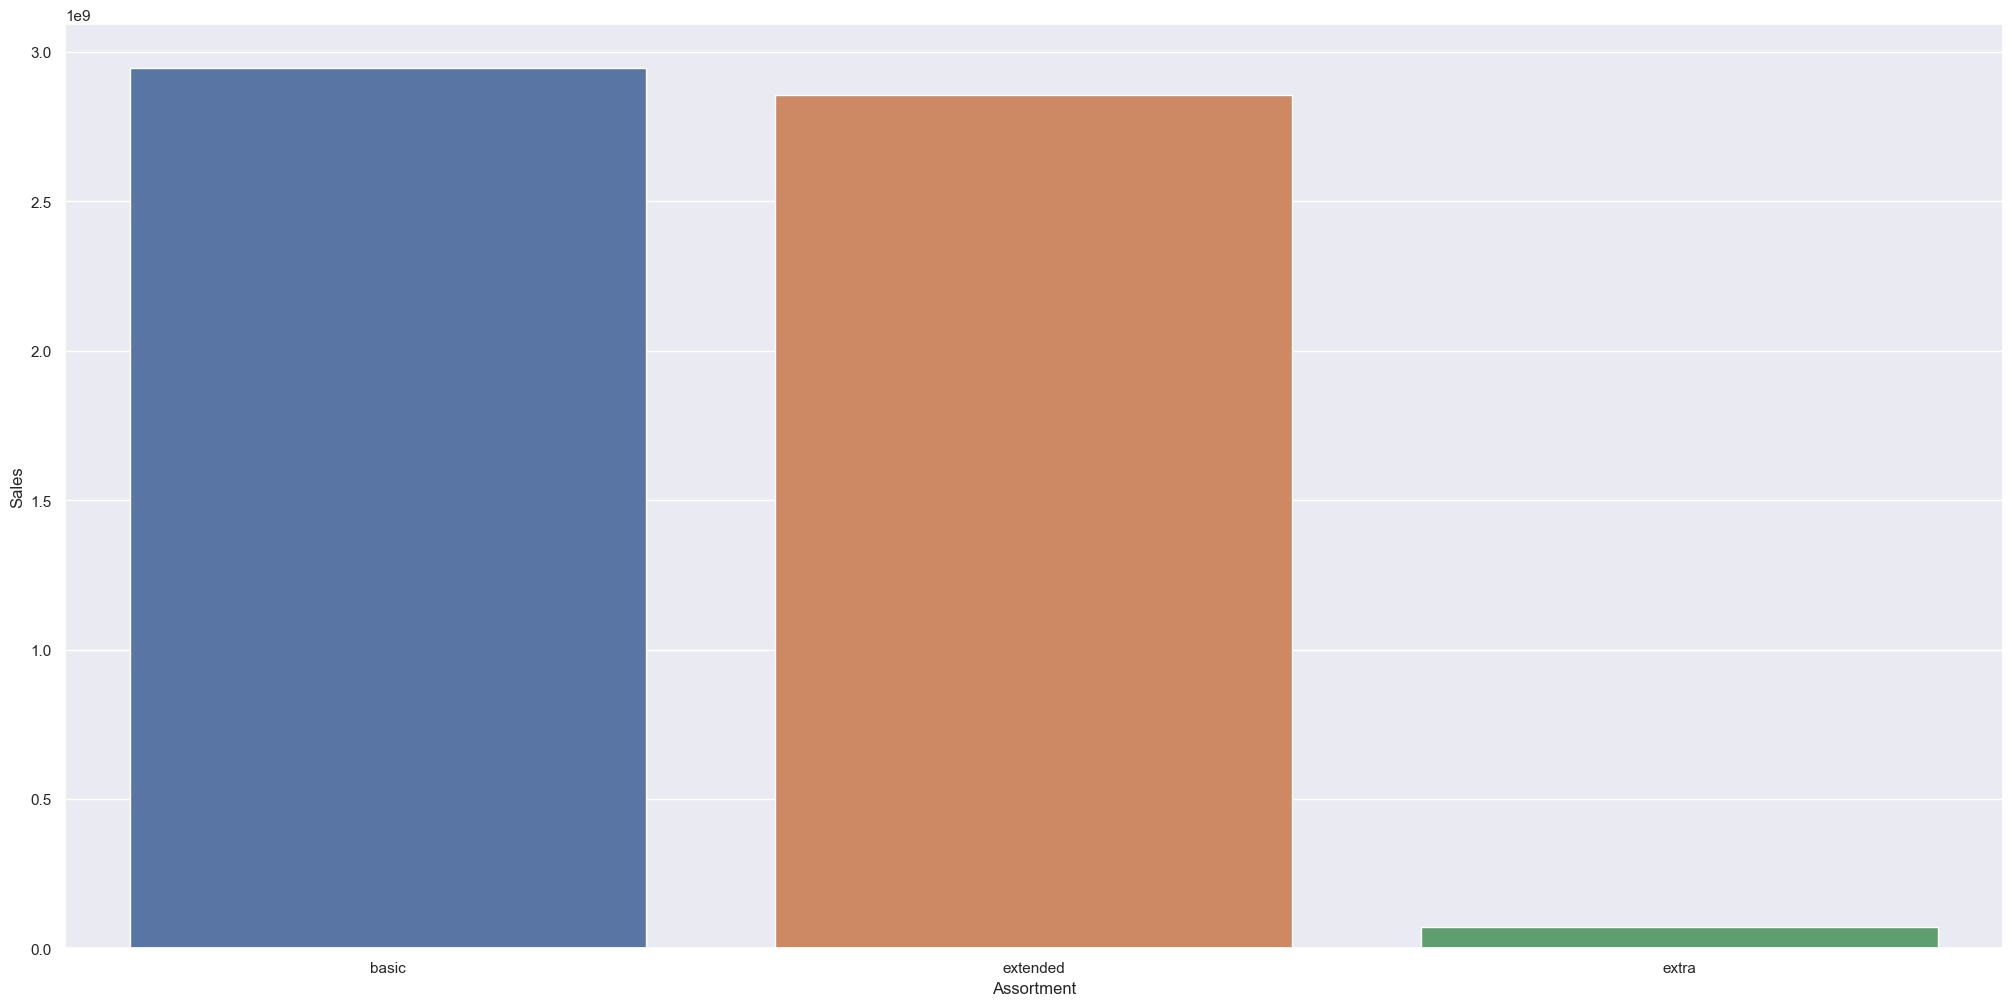

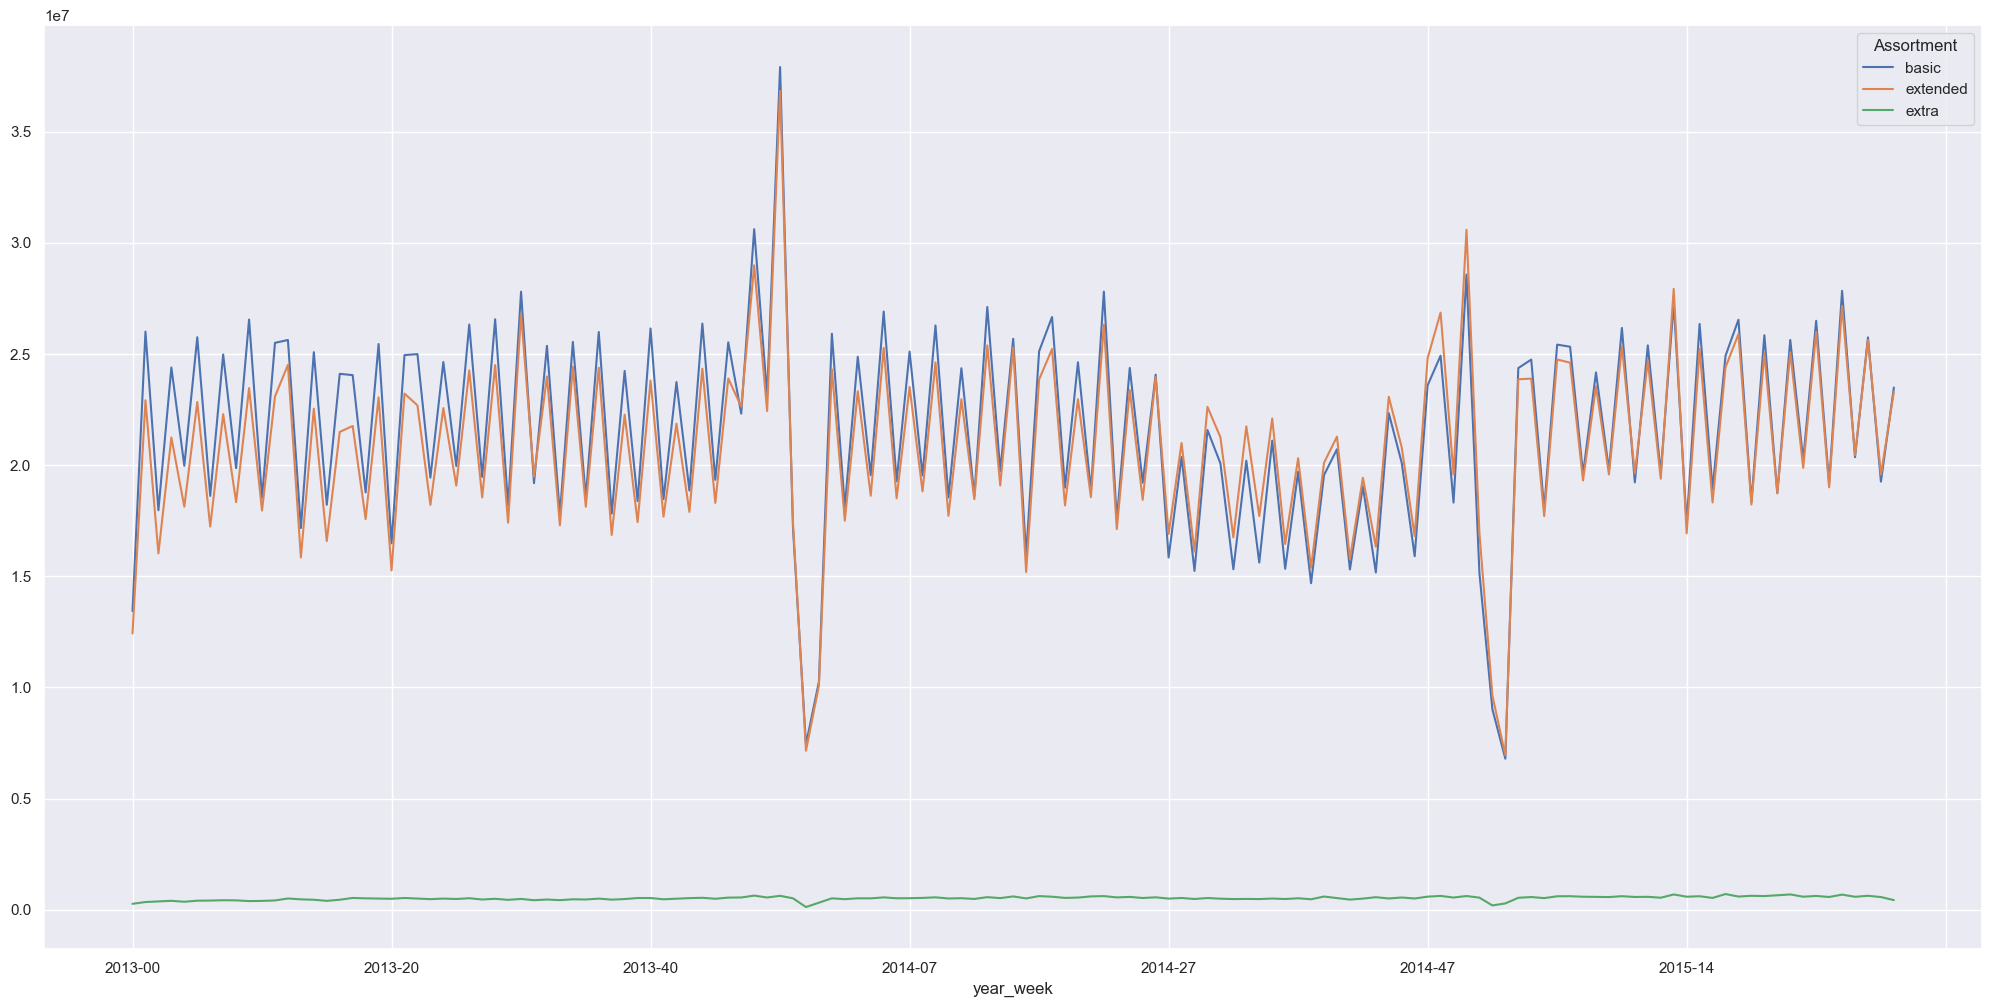

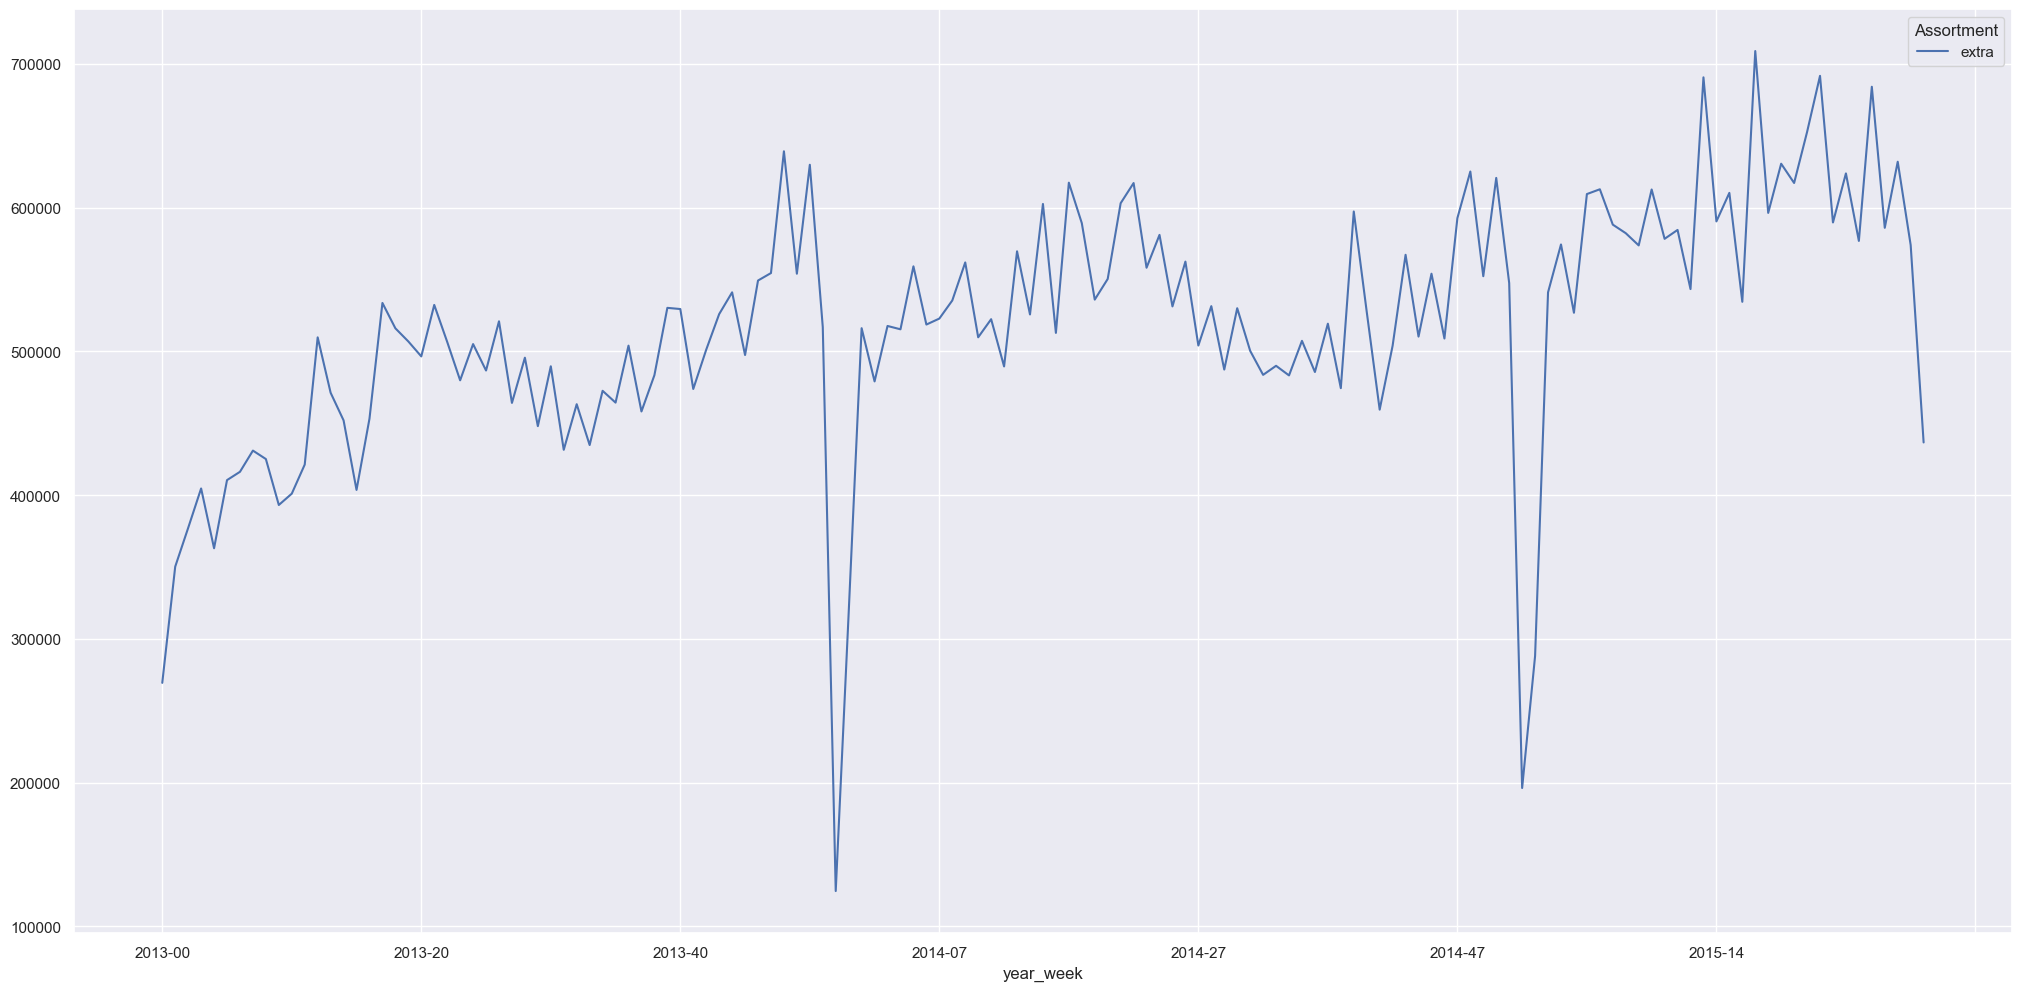

In [61]:
# Soma de todas as vendas das lojas que tem sortimento: básico, extendido e extra
# Percebe-se que as vendas de lojas com sortimento básico e estendido é muito parecido, mas o extra é bem menor
aux1 = df4[['Assortment', 'Sales']].groupby('Assortment').sum().reset_index()
sns.barplot(x='Assortment', y='Sales', data=aux1);

# Gráfico para saber se ao longo do tempo (ano e semana), o extra pode ter sido uma estratégia apenas do passado 
aux2 = df4[['year_week','Assortment','Sales']].groupby(['year_week','Assortment']).sum().reset_index()
aux2.head()
aux2.pivot( index='year_week', columns='Assortment', values='Sales').plot()
           
# Gráfico para observar apenas o sortimento extra
# Não é linear, tem um comportamento diferente do que aparece no gráfico anterior
aux3 = aux2[aux2['Assortment'] == 'extra']
aux3.pivot(index='year_week', columns='Assortment', values='Sales').plot()

### H2. Lojas com competidores mais próximos vendem MENOS
###### FALSA -> Lojas com competidores mais próximos vendem MAIS

C:\Users\deeww\AppData\Local\Temp\ipykernel_8348\4274310913.py:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );


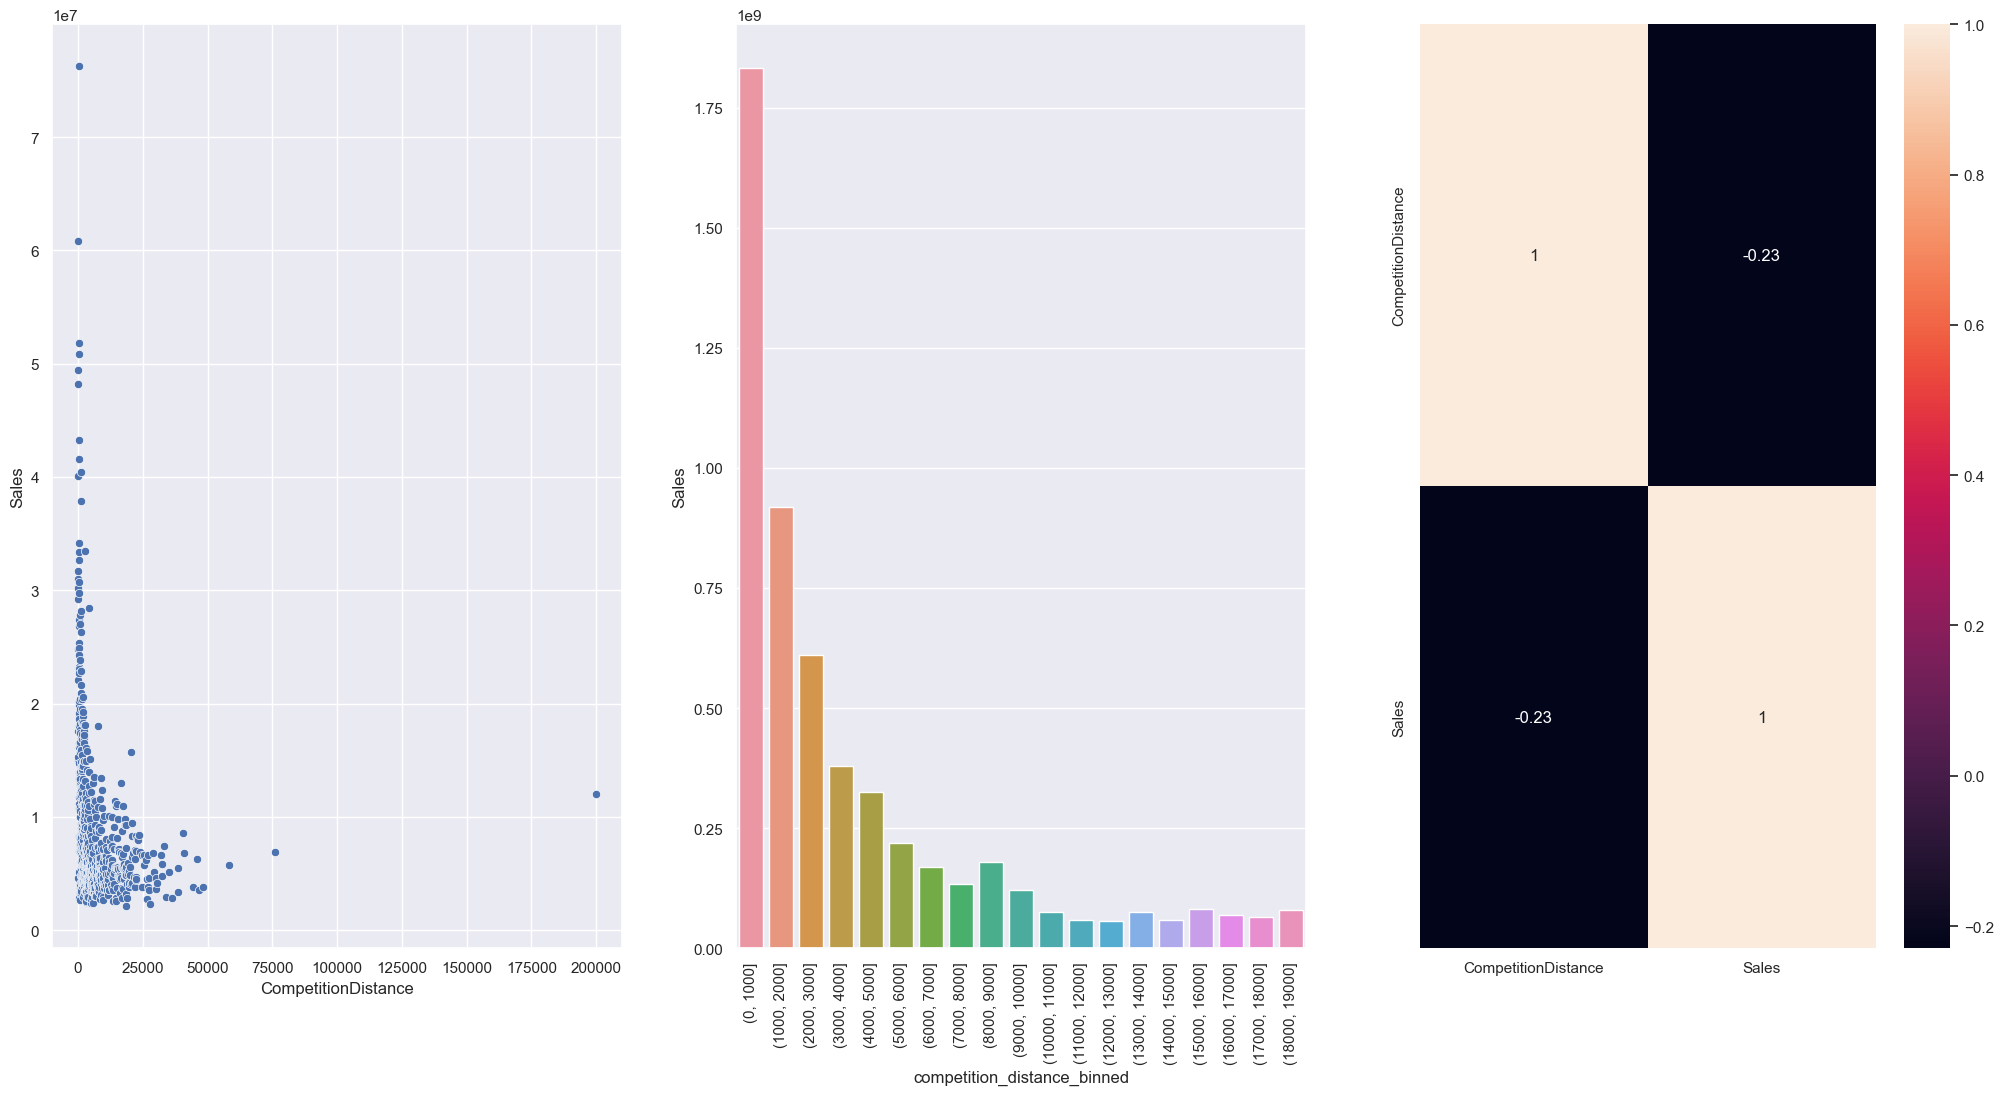

In [64]:
################### Ver a media
# Ver o volume de vendas pela distância dos competidores
aux1 = df4[['CompetitionDistance', 'Sales']].groupby( 'CompetitionDistance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='CompetitionDistance', y='Sales', data=aux1 );

# Agrupando por distância (bins)
plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['CompetitionDistance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'Sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='Sales', data=aux2 );
plt.xticks( rotation=90 );

# Correlação entre as vendas e a distância dos competidores (quanto mais distante, menor a venda: correlação negativa)
plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()

### H3. Lojas com competidores há mais tempo vendem MAIS
###### FALSA -> Lojas com competidores há mais tempo vendem MENOS

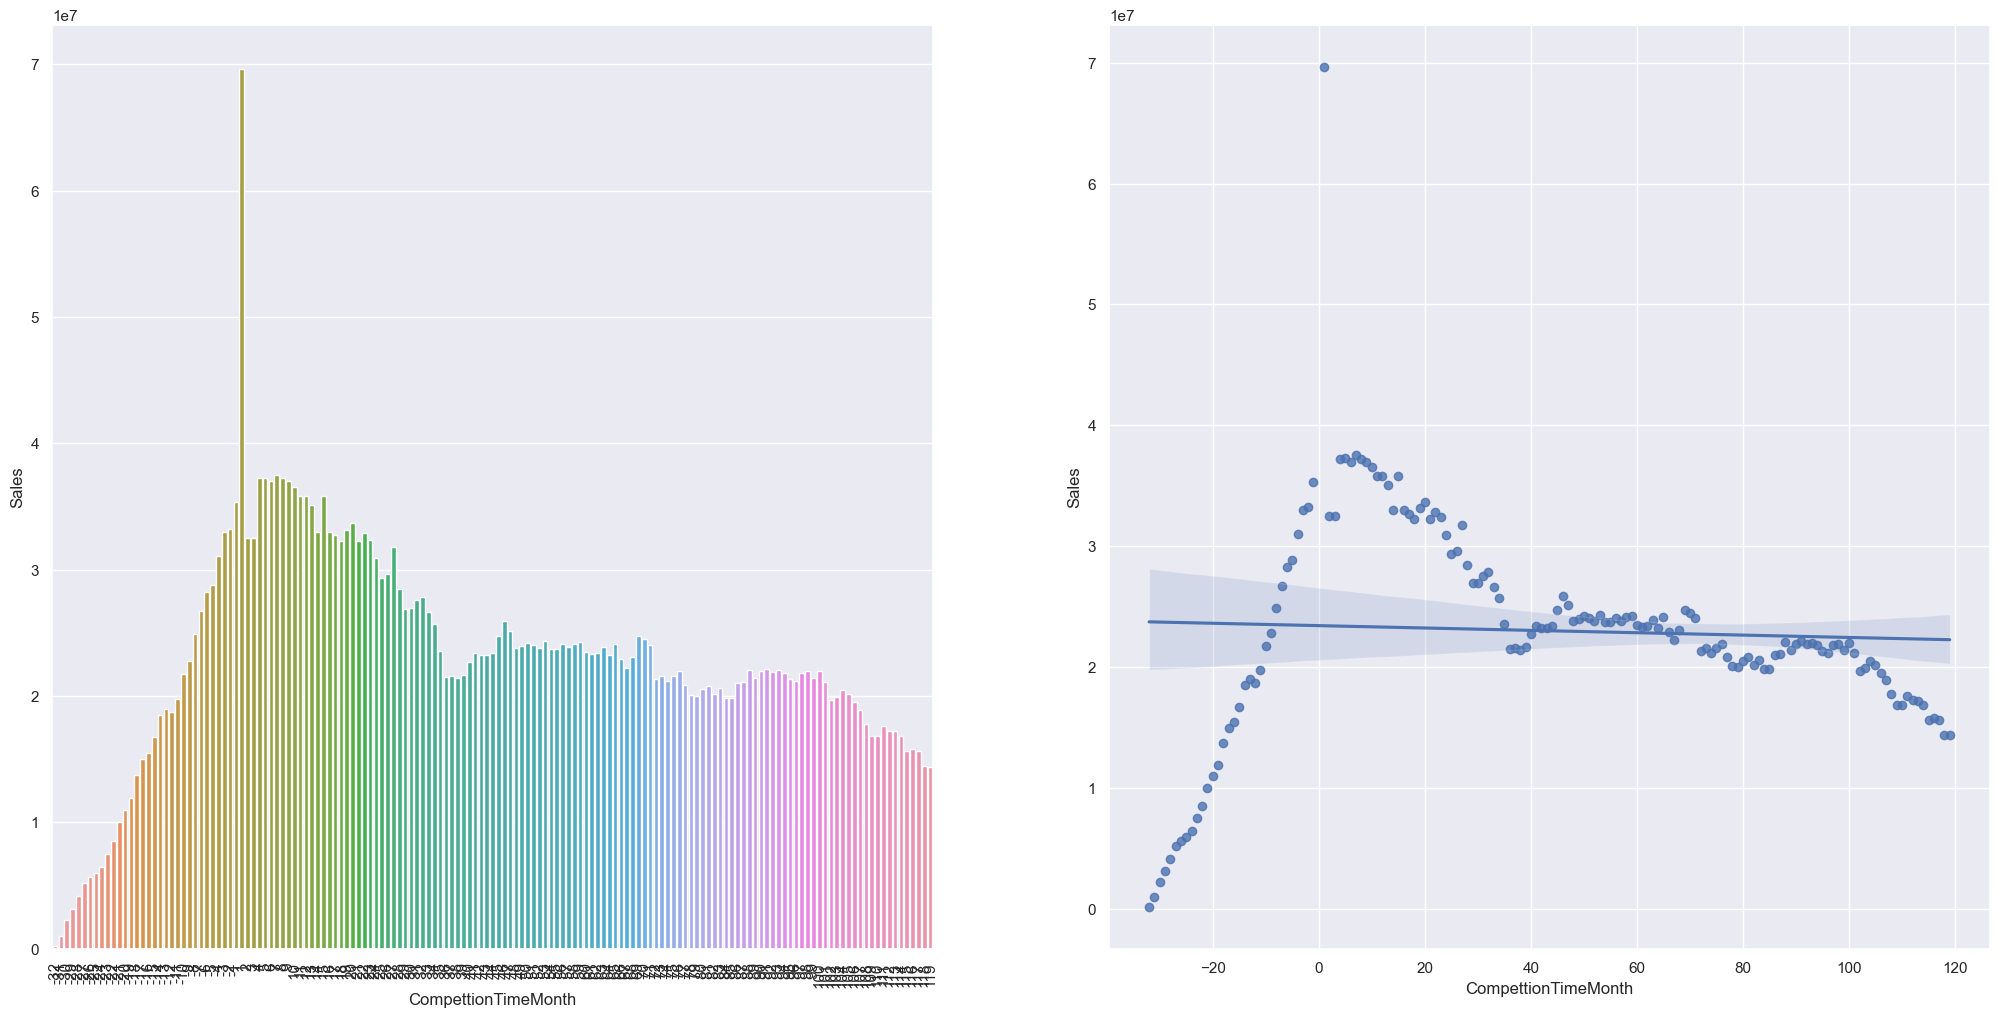

In [74]:
###############Ver a média
#Como o tempo influencia na venda?
# Quanto mais recente é a competição maior é a venda.
plt.subplot( 1, 2, 1 )
aux1 = df4[['CompettionTimeMonth', 'Sales']].groupby( 'CompettionTimeMonth' ).sum().reset_index()

# Filtro: menos de 120 meses e diferentes de zero
aux2 = aux1[( aux1['CompettionTimeMonth'] < 120 ) & ( aux1['CompettionTimeMonth'] != 0 )]
sns.barplot( x='CompettionTimeMonth', y='Sales', data=aux2 );
plt.xticks( rotation=90 );

# É preciso usar a coluna de tempo - mês
plt.subplot( 1, 2, 2 )
sns.regplot( x='CompettionTimeMonth', y='Sales', data=aux2 );


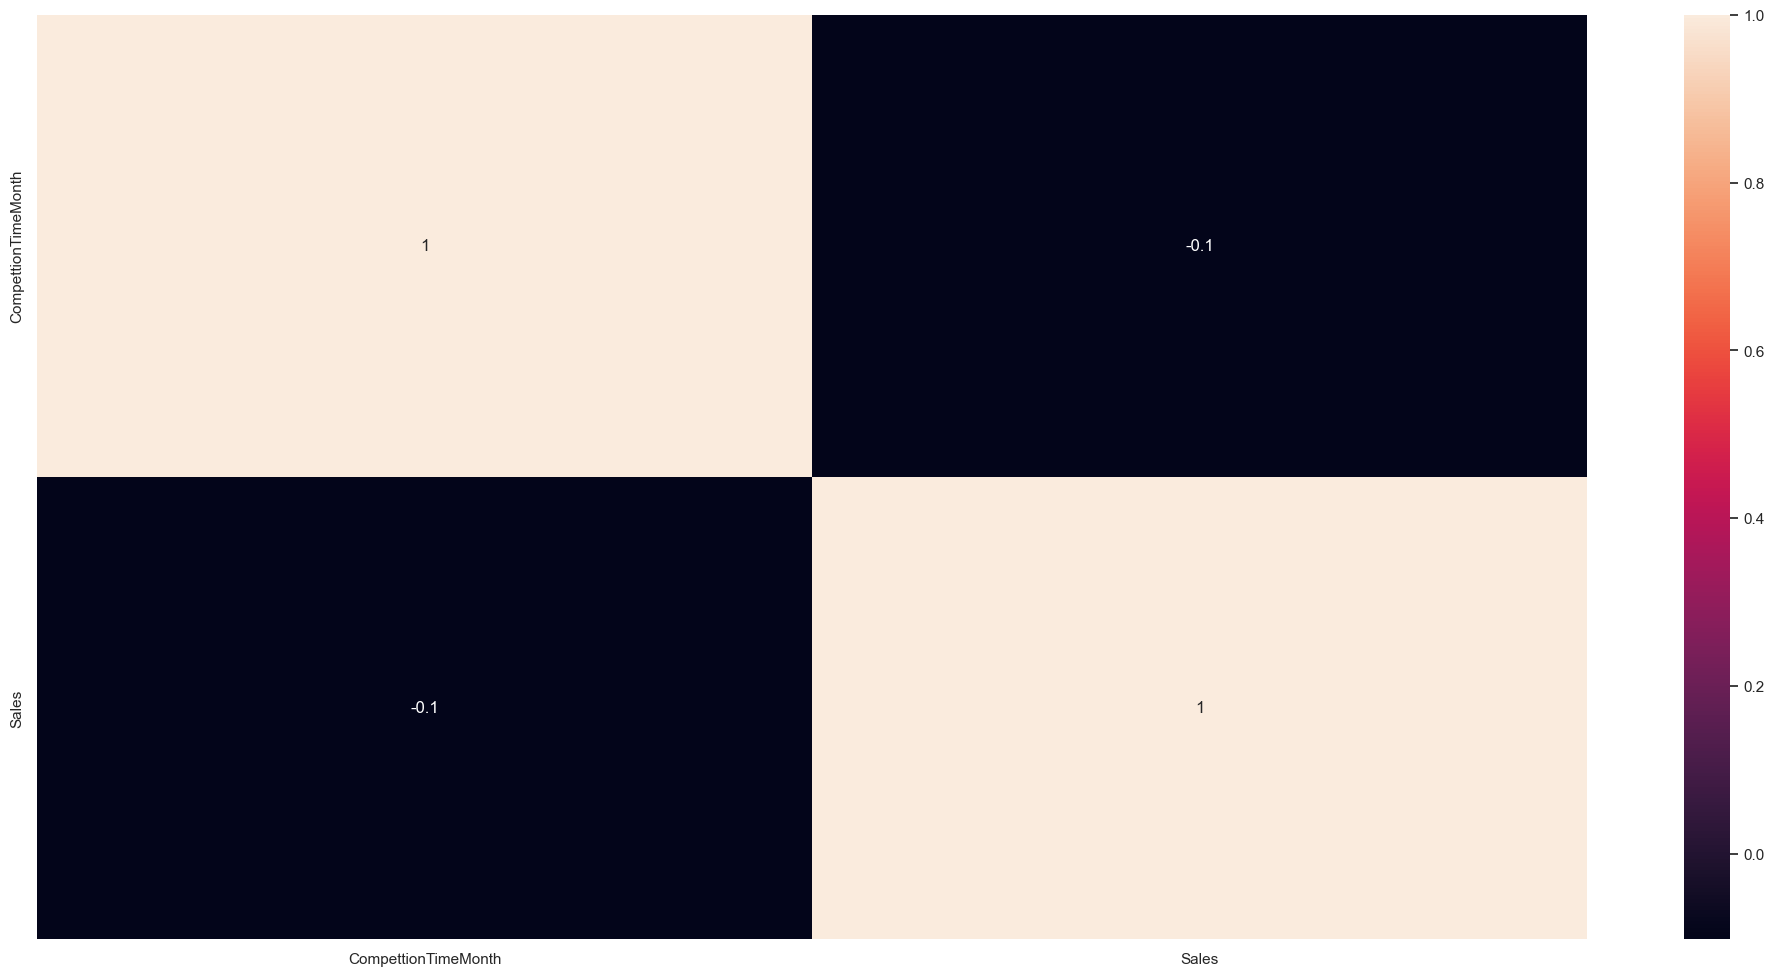

In [76]:

# Correlação
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );


### H4. Lojas com promoções ativas por mais tempo vendem MAIS
###### FALSA -> Lojas com promoções ativas por mais tempo vendem menos, depois de certo período de promoção

In [77]:
df4.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'is_promo', 'Month', 'Day',
       'week_of_year', 'year_week', 'CompetitionSince', 'CompettionTimeMonth',
       'promo_since', 'promo_time_week'],
      dtype='object')

C:\Users\deeww\AppData\Local\Temp\ipykernel_8348\2758396946.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


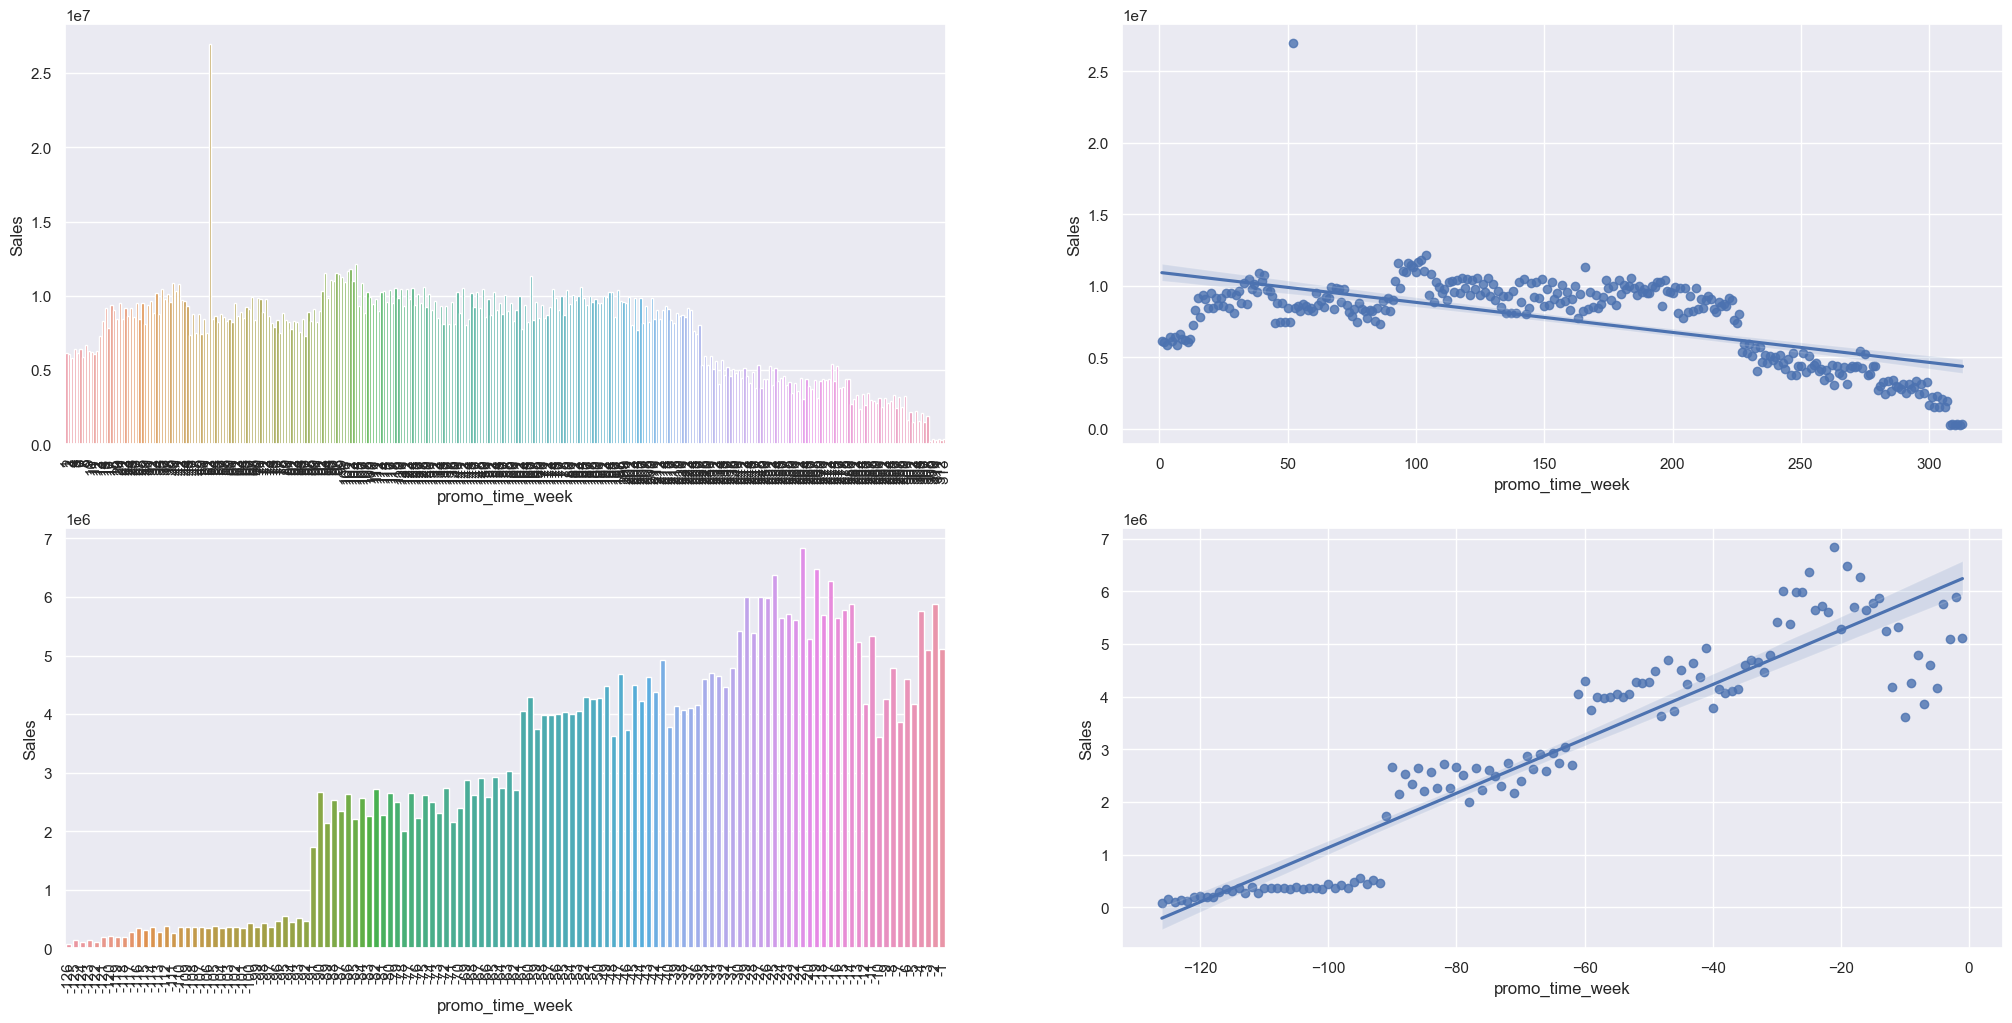

In [78]:
# Existem dois contextos - dois período de promoção: tradicional(Promo) e estendida (Promo2)
## Promo time week negativa, significa que a venda foi feita no período tradicional de promoções
## Promo time week positiva, significa que a venda foi realizada na promoção estendida
## A promoção estendida funciona até um período, depois começa a cair (então, promoção muito longa não funciona)
## Para o ML Promo time week sem a dicisão Promo, Promo2. Porque para o modelo é melhor, a divisão só serve para enxergar mesmo. 

aux1 = df4[['promo_time_week', 'Sales']].groupby( 'promo_time_week').sum().reset_index()
sns.barplot(x='promo_time_week', y='Sales', data=aux1);

# Separando as promoções: tradicional e estendida
plt.subplot(2,2,1)
aux2 = aux1[aux1['promo_time_week'] > 0] # promo estendido
sns.barplot( x='promo_time_week', y='Sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot(2,2,2)
sns.regplot( x='promo_time_week', y='Sales', data=aux2 );

plt.subplot(2,2,3)
aux3 = aux1[aux1['promo_time_week'] < 0] # promo tradicional
sns.barplot( x='promo_time_week', y='Sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot(2,2,4)
sns.regplot( x='promo_time_week', y='Sales', data=aux3 );


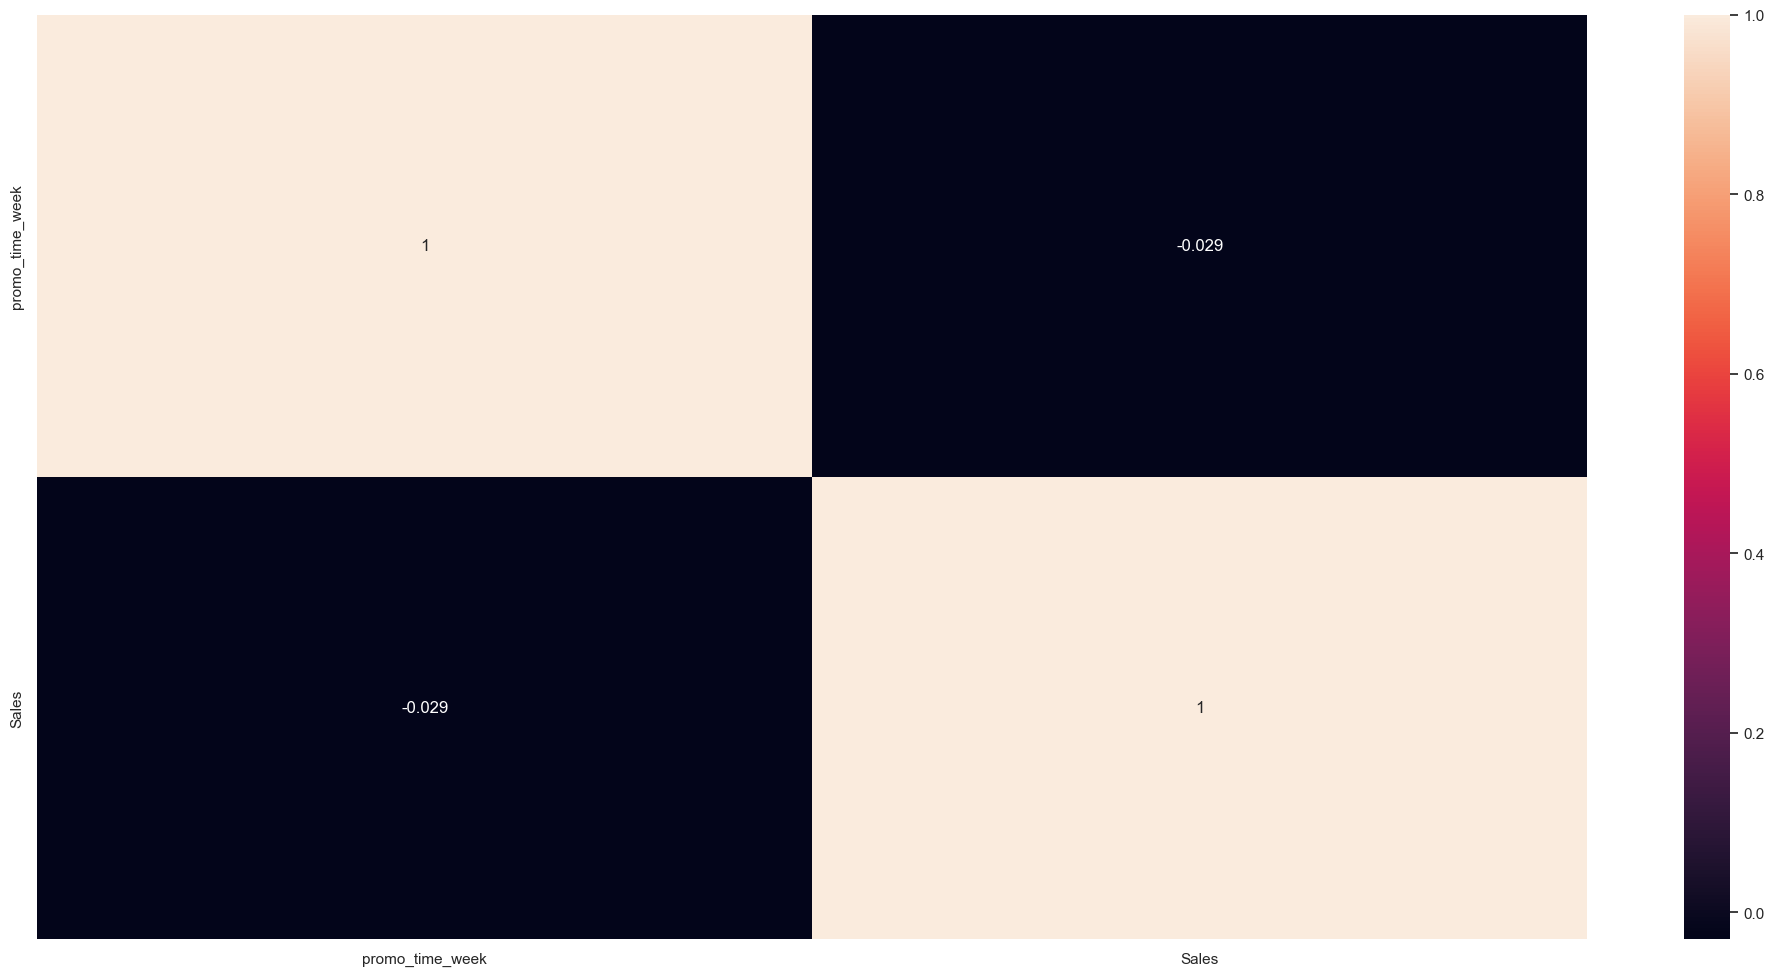

In [79]:
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H5. Lojas com mais dias de promoção deveriam vender mais

### H7. Lojas com promoções mais consecutivas vendem MAIS
###### FALSA -> Lojas com promoções mais consecutivas vendem menos

In [80]:
## Lojas que participaram apenas de uma promoção, venderam mais (2)
df4[['Promo', 'Promo2', 'Sales']].groupby(['Promo', 'Promo2']).sum().reset_index()

,Promo,Promo2,Sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


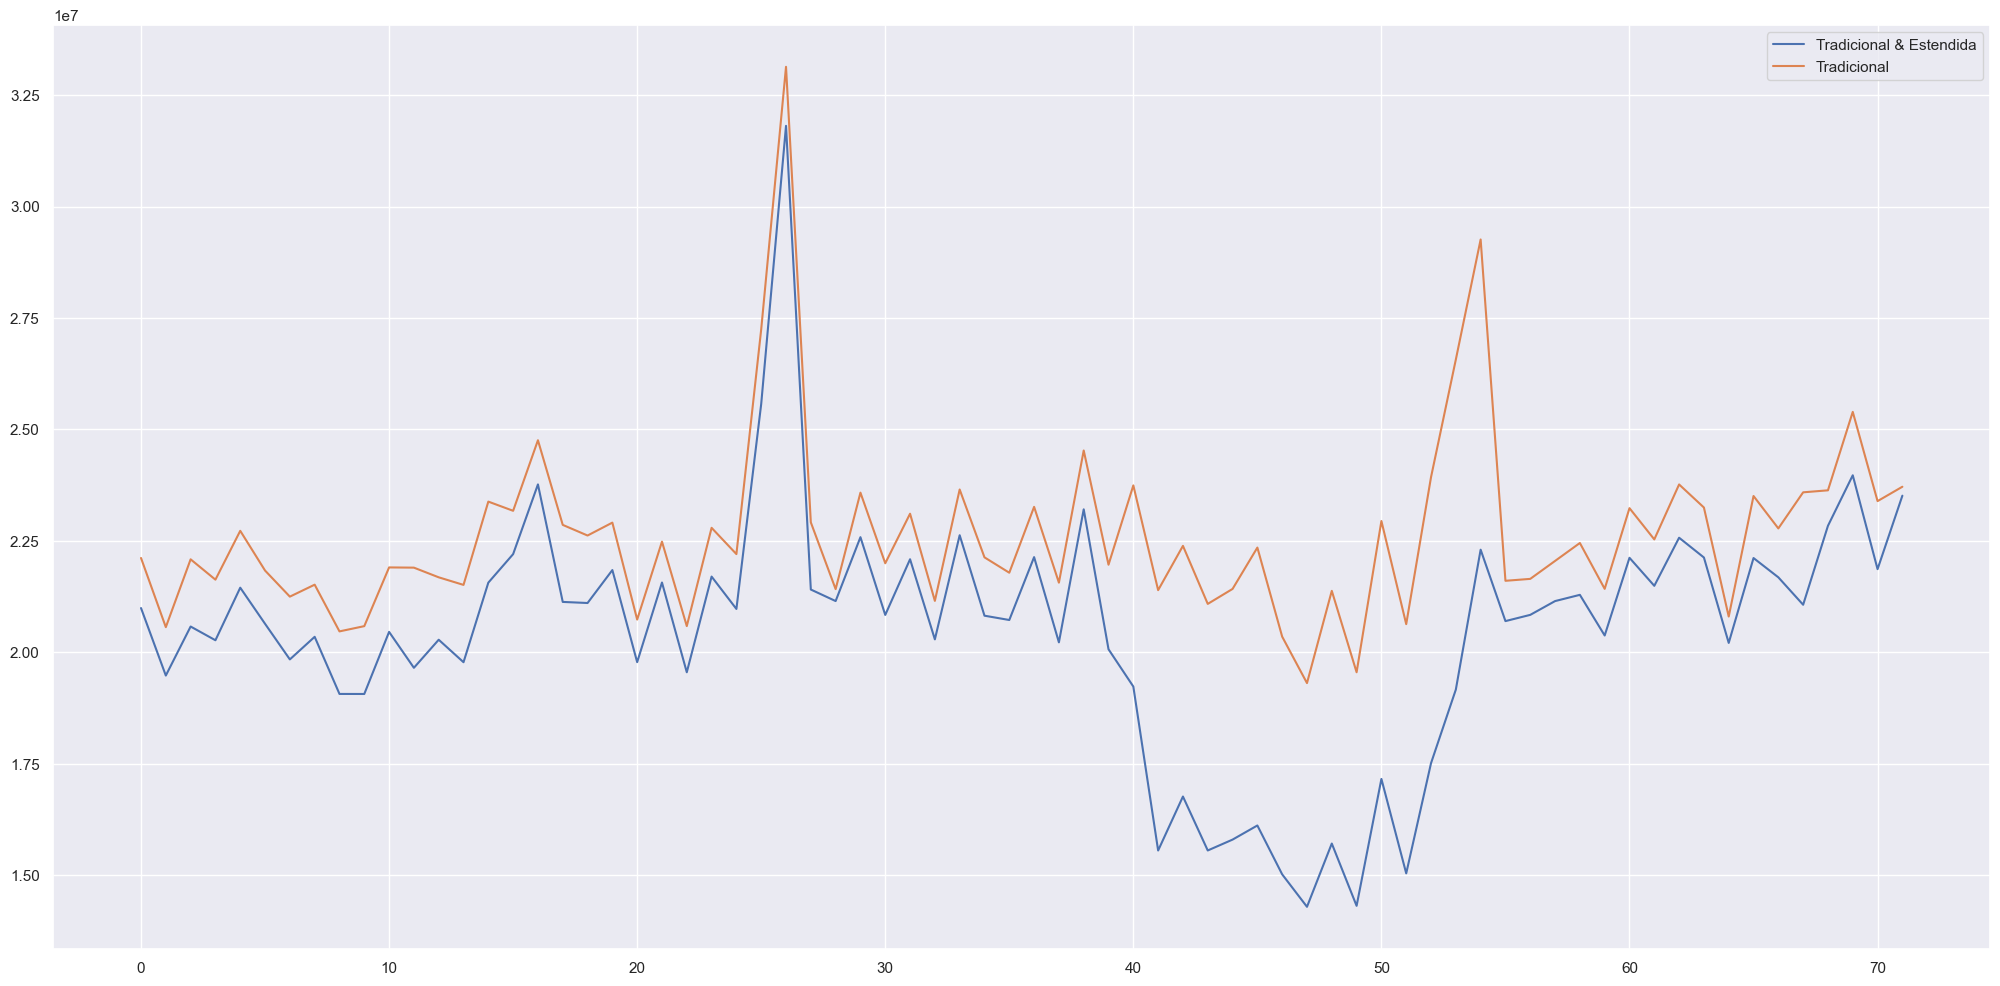

In [81]:
# Filtro 1: todas as lojas que participaram da promoção tradicional e estenderam a promoção (ao longo do tempo)
aux1 = df4[( df4['Promo'] == 1 ) & ( df4['Promo2'] == 1 )][['year_week', 'Sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

# Filtro 2: todas as lojas que só participaram da tradicional
aux2 = df4[( df4['Promo'] == 1 ) & ( df4['Promo2'] == 0 )][['year_week', 'Sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Estendida', 'Tradicional']);

### H8. Lojas abertas durante o feriado de Natal vendem MAIS
###### FALSA -> Lojas abertas durante o feriado de natal, vendem menos

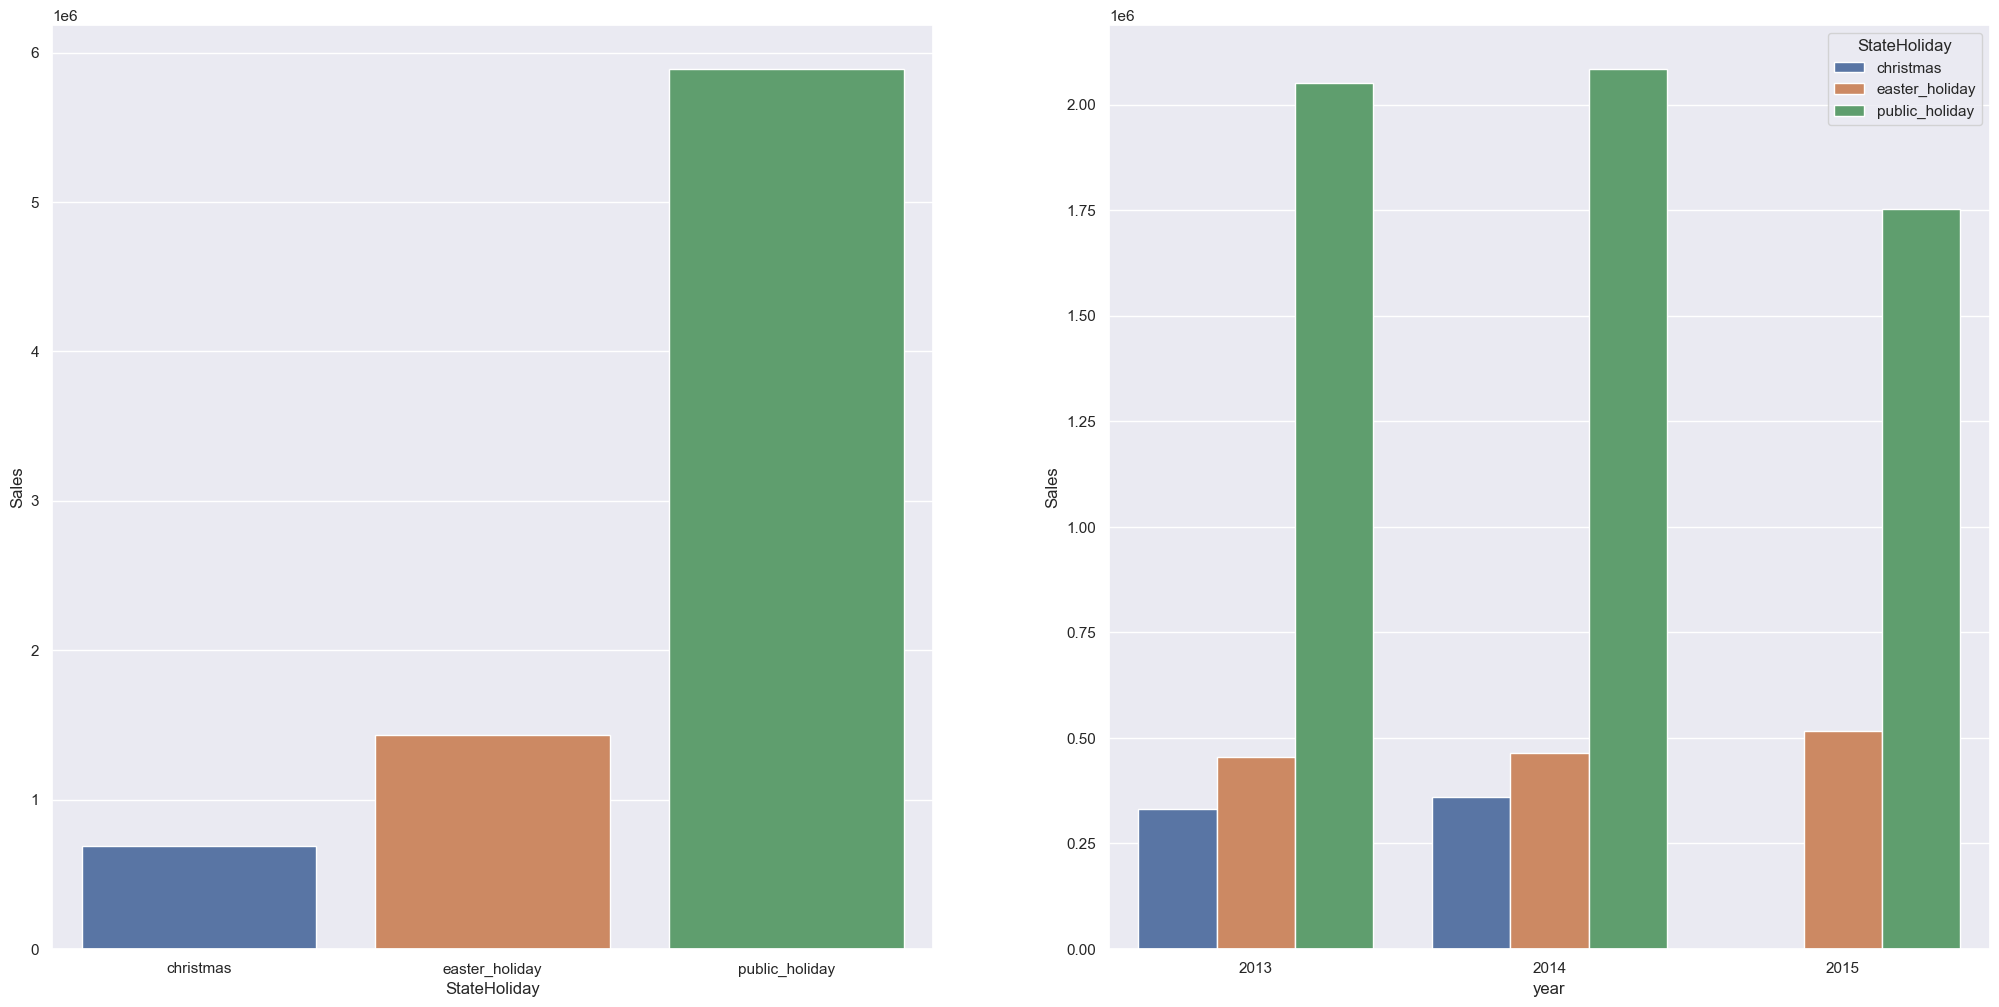

In [23]:
aux = df4[df4['StateHoliday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['StateHoliday', 'Sales']].groupby( 'StateHoliday' ).sum().reset_index()
sns.barplot( x='StateHoliday', y='Sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'StateHoliday', 'Sales']].groupby( ['year', 'StateHoliday'] ).sum().reset_index()
sns.barplot( x='year', y='Sales', hue='StateHoliday', data=aux2 );

In [86]:
aux.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'is_promo', 'Month', 'Day',
       'week_of_year', 'year_week', 'CompetitionSince', 'CompettionTimeMonth',
       'promo_since', 'promo_time_week'],
      dtype='object')

In [84]:
df4.columns


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'is_promo', 'Month', 'Day',
       'week_of_year', 'year_week', 'CompetitionSince', 'CompettionTimeMonth',
       'promo_since', 'promo_time_week'],
      dtype='object')

### H9. Lojas deveriam vender mais ao longo dos anos
###### FALSA -> Lojas vendem menos ao longo dos anos

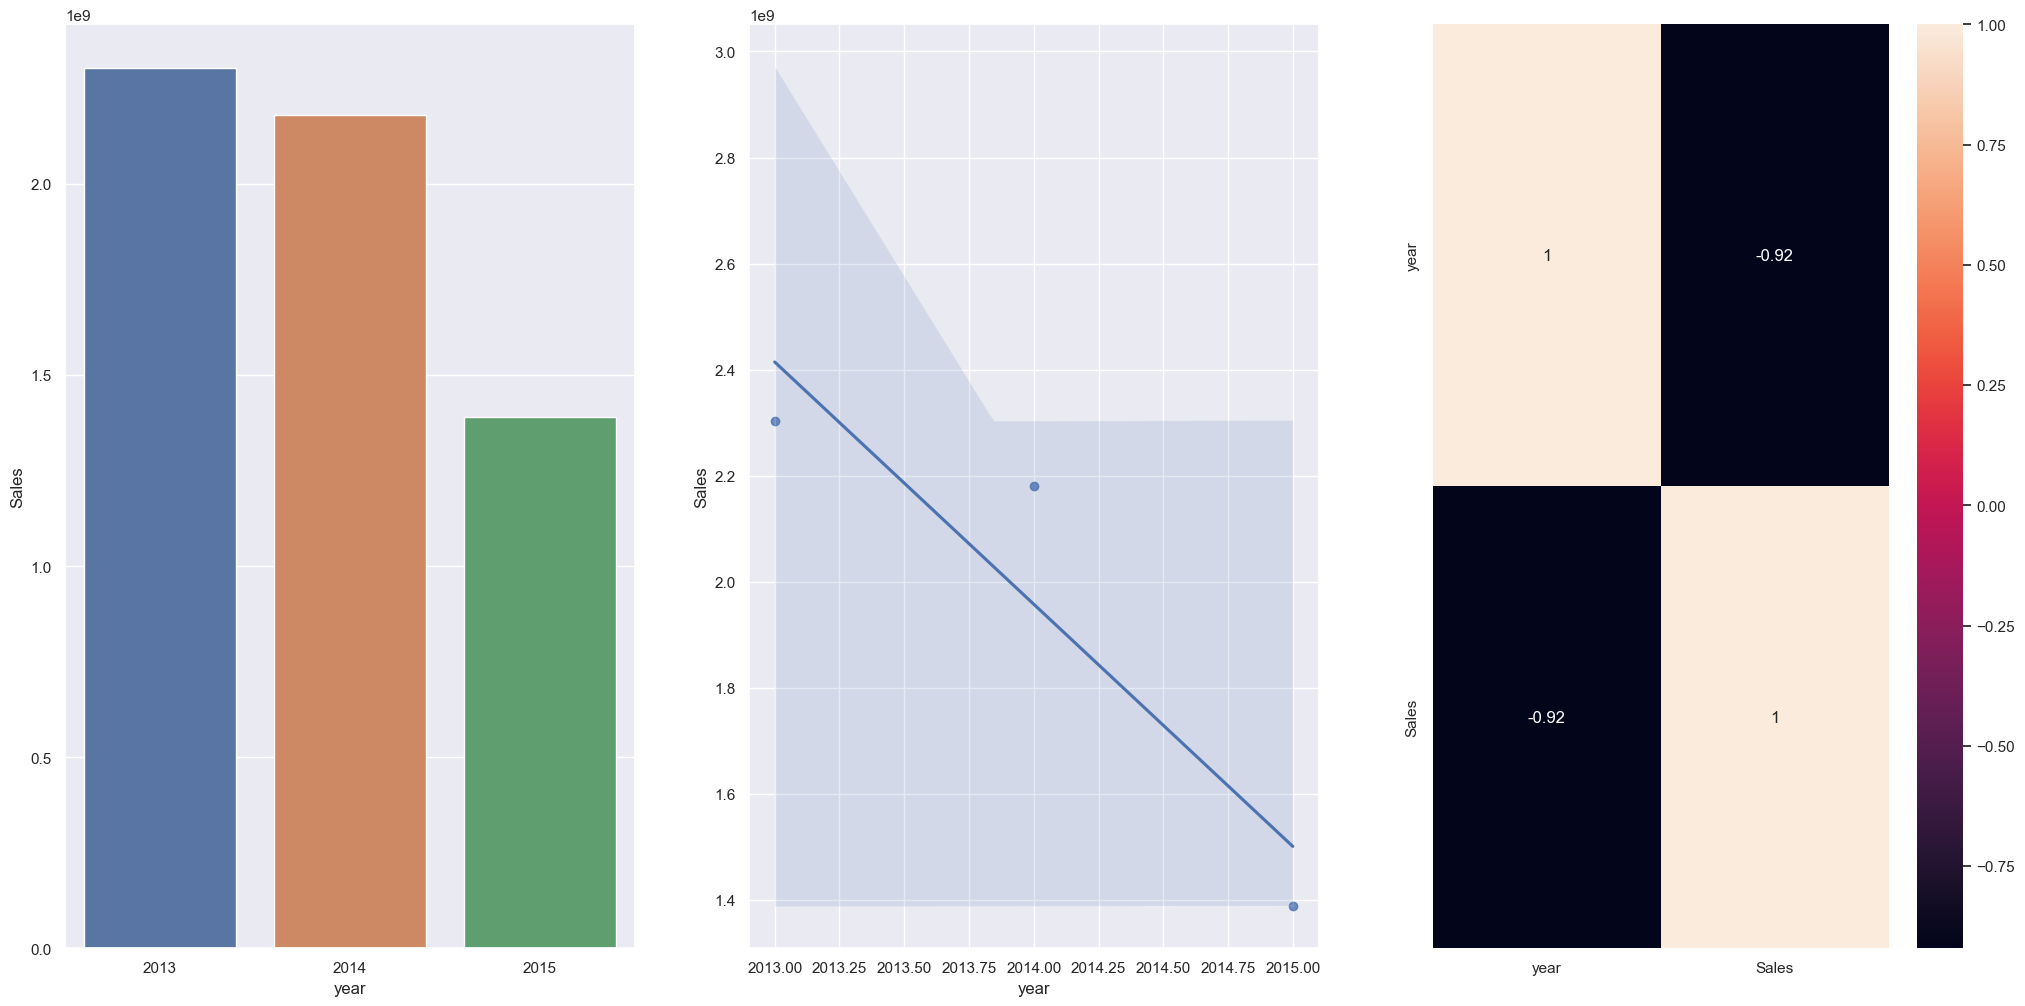

In [106]:
aux1 = df4[['year', 'Sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='Sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='Sales', data=aux1 ); # tendência

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True ); # correlação (aumentam os anos e diminui as vendas)

# É preciso observar que a correlação é muito alta porque o ano de 2015 não está fechado

### H10. Lojas deveriam vender mais no segundo semestre do ano 
###### FALSA ->  Lojas vendem menos no segundo semestre do ano

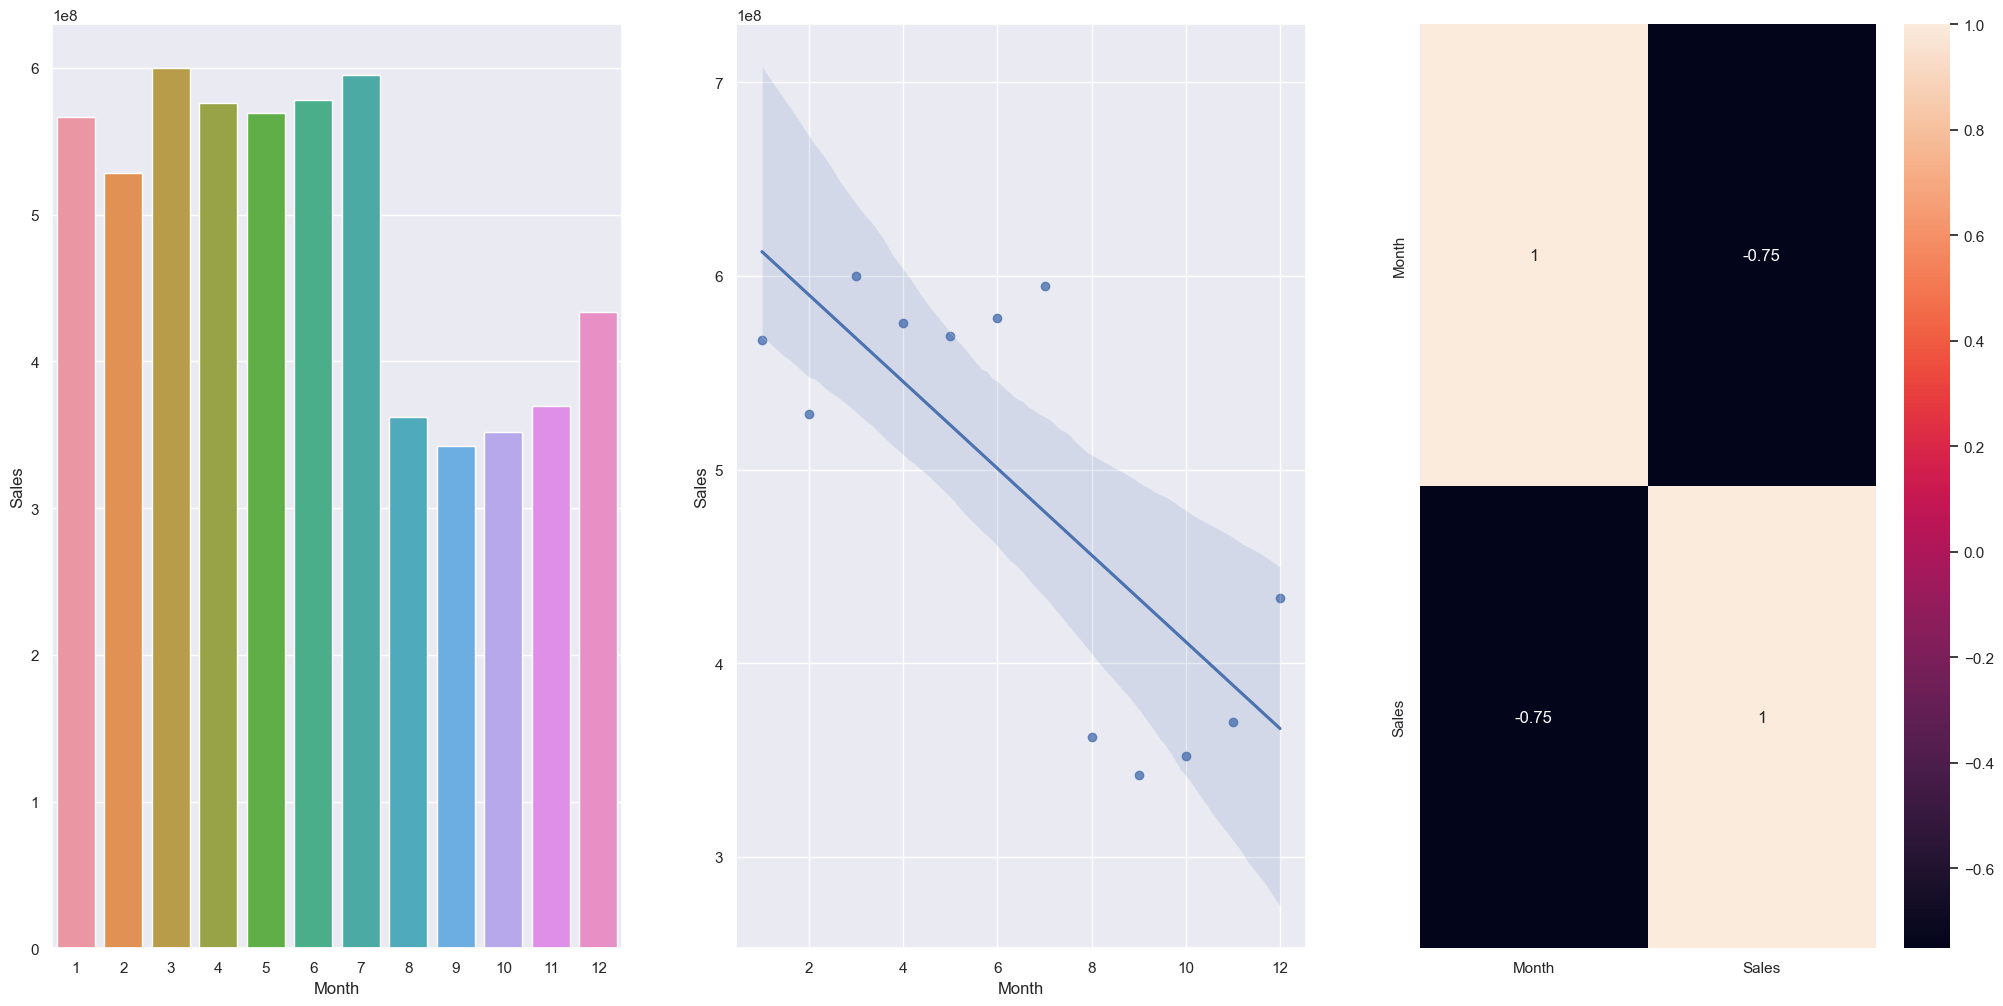

In [107]:
aux1 = df4[['Month', 'Sales']].groupby( 'Month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='Month', y='Sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='Month', y='Sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H11. Lojas deveriam vender mais depois do dia 10 de cada mês
###### VERDADEIRA ->  Lojas vendem mais depois do dia 10 de cada mês

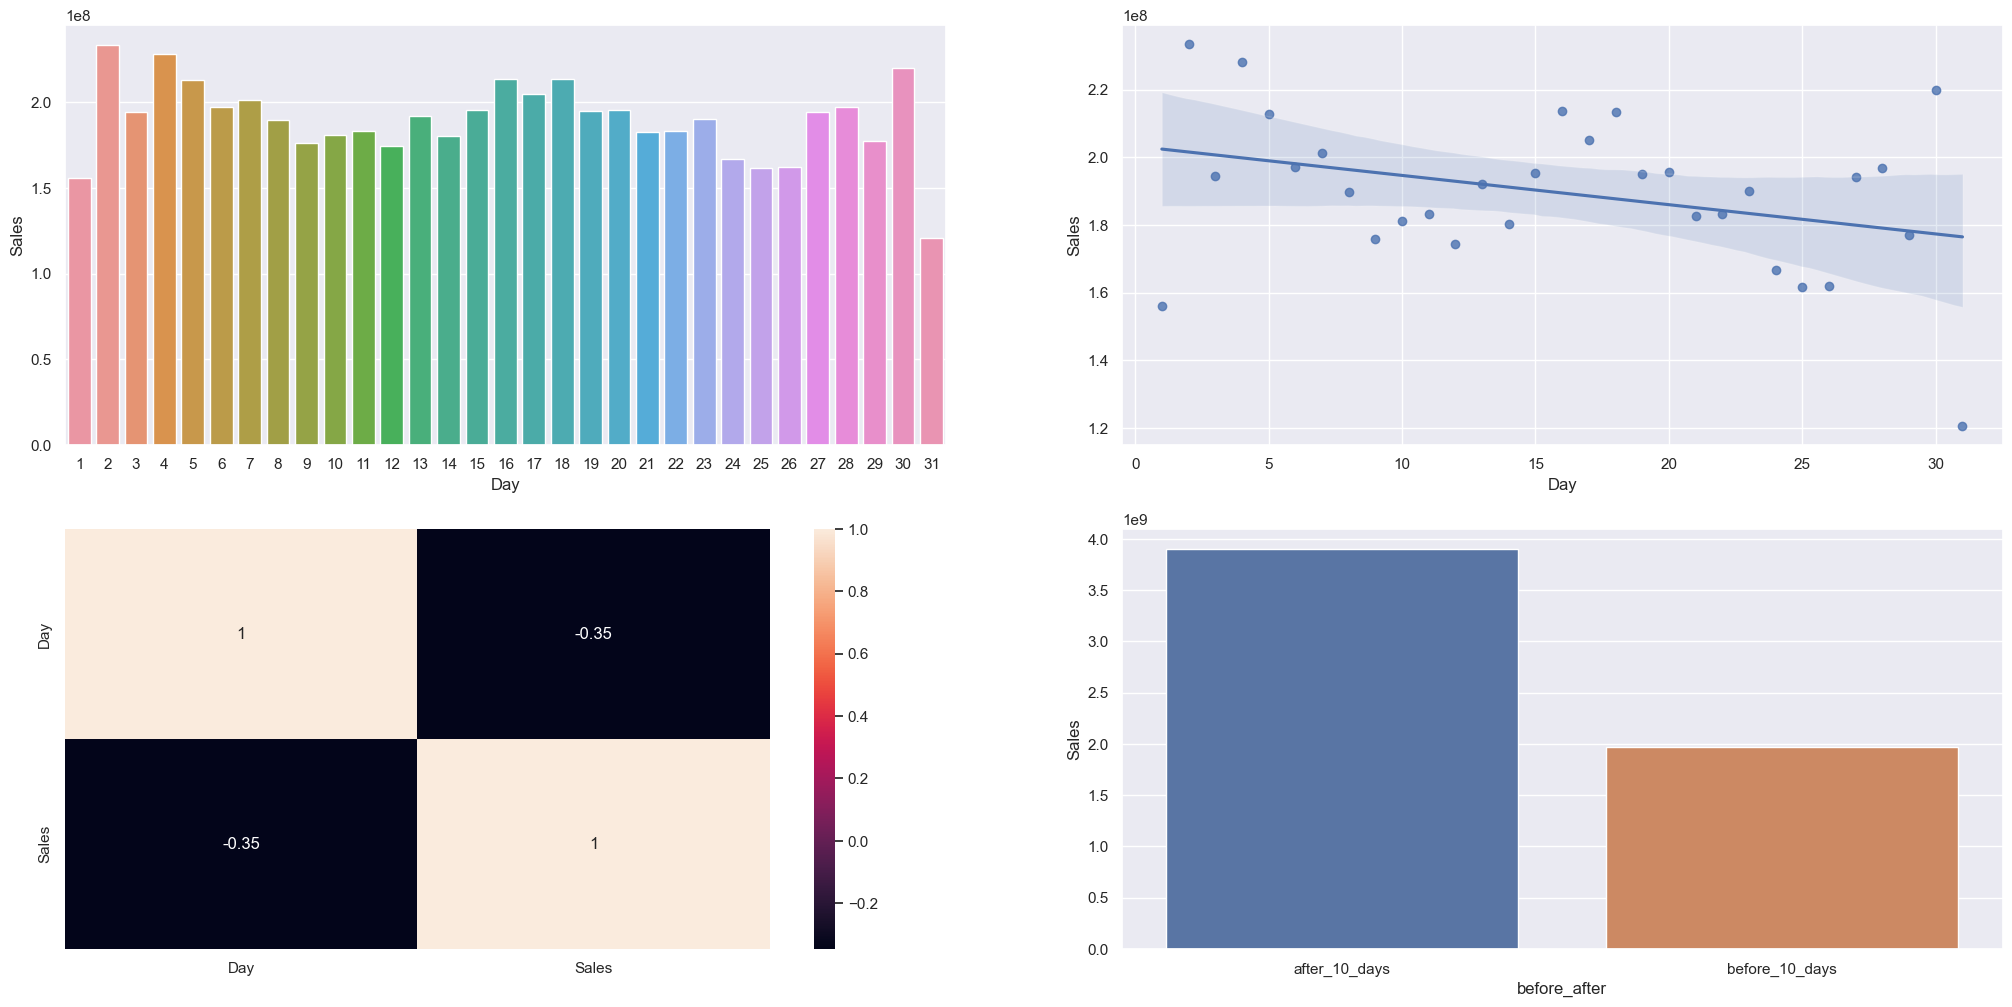

In [108]:
aux1 = df4[['Day', 'Sales']].groupby( 'Day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='Day', y='Sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='Day', y='Sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['Day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'Sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='Sales', data=aux2 );

### H12. Lojas deveriam vender menos nos finais de semana
###### VERDADEIRA ->  Lojas vendem menos nos finais de semana

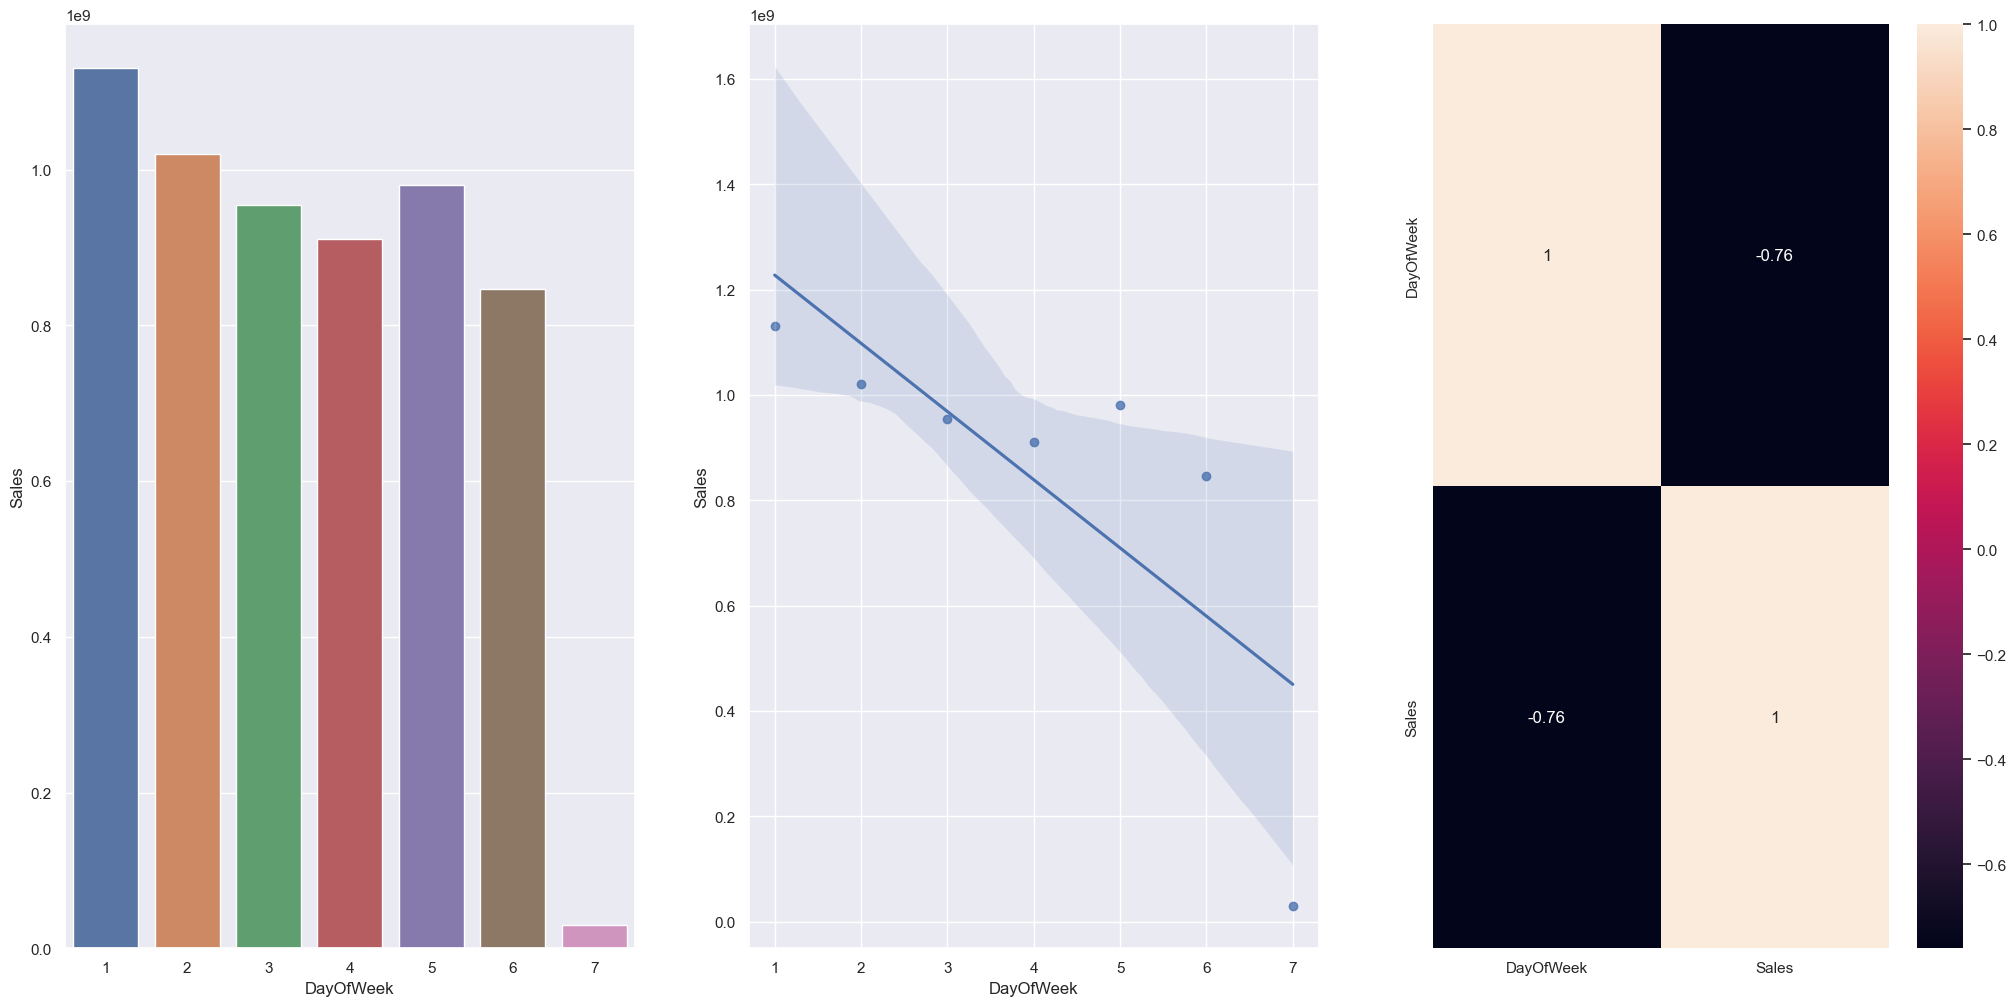

In [109]:
aux1 = df4[['DayOfWeek', 'Sales']].groupby( 'DayOfWeek' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='DayOfWeek', y='Sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='DayOfWeek', y='Sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H13. Lojas deveriam vender menos nos feriados escolares
###### VERDADEIRA ->  Lojas vendem menos nos feriados escolares, exceto nos meses de julho e agosto

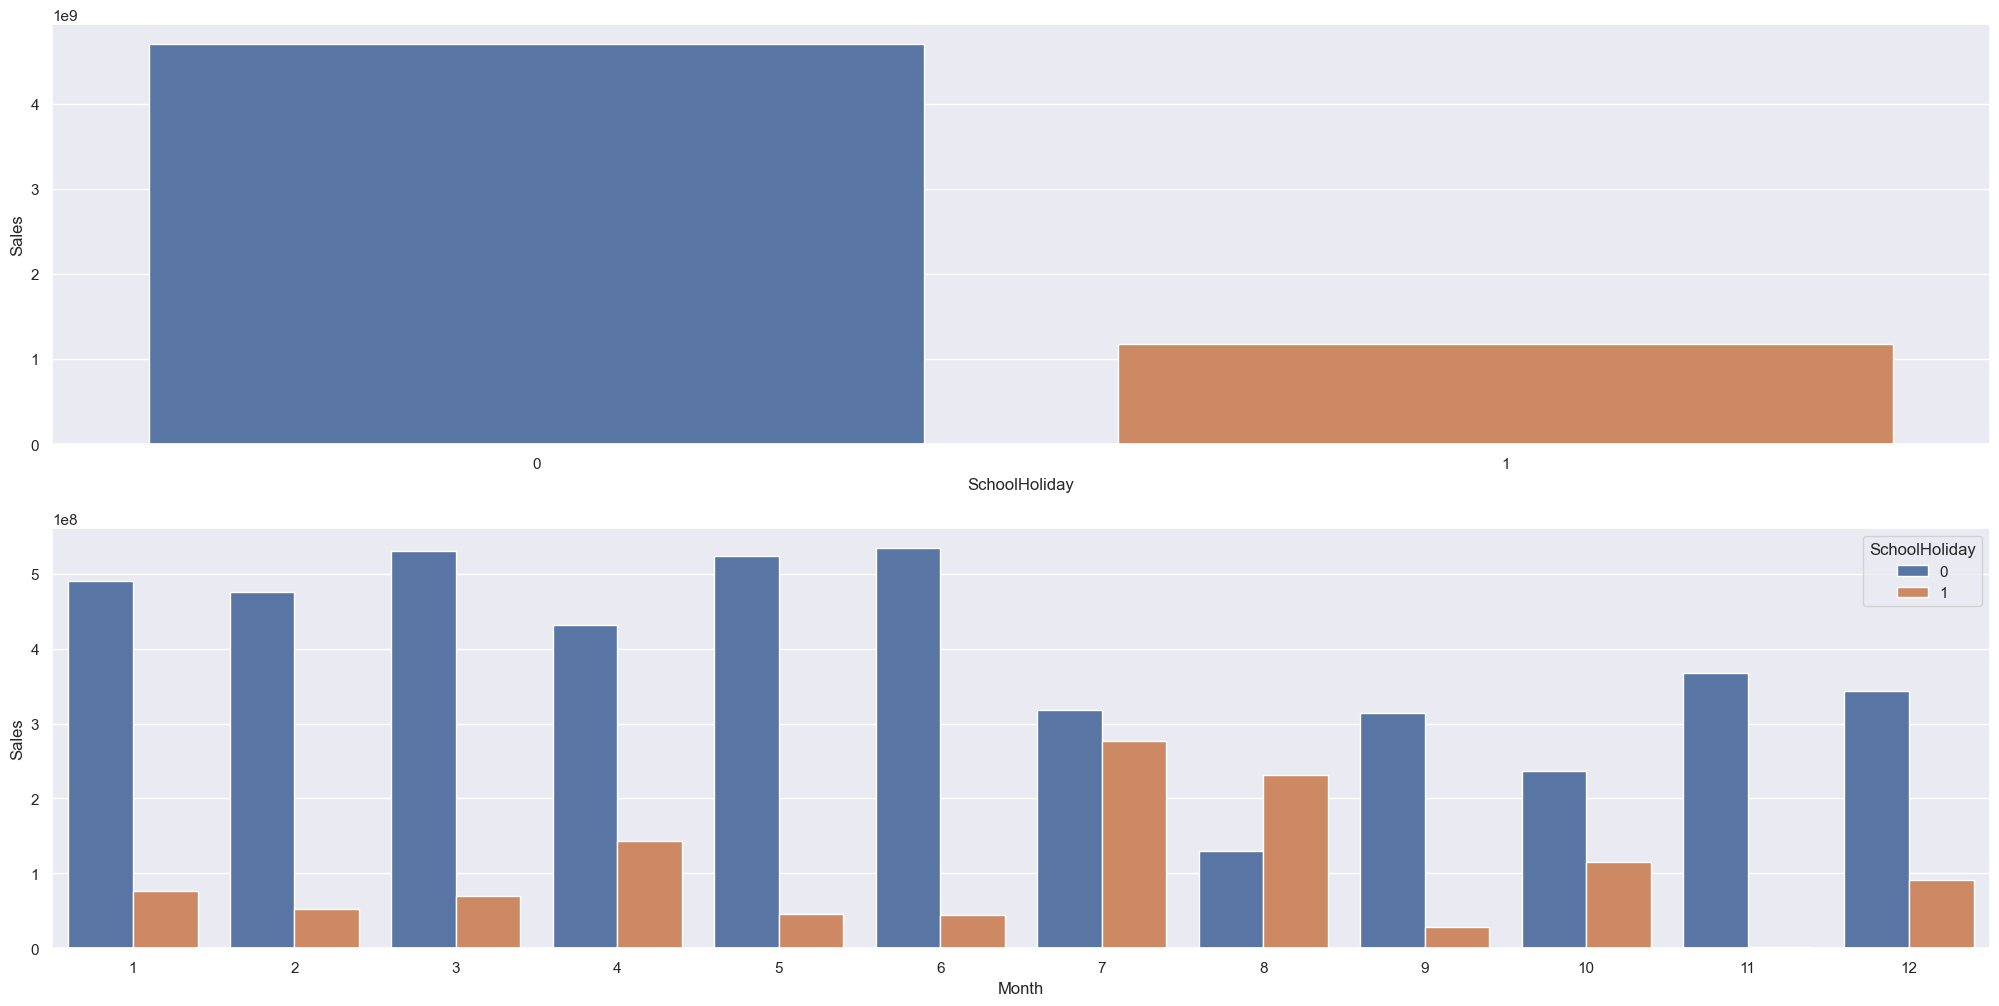

In [110]:
aux1 = df4[['SchoolHoliday', 'Sales']].groupby( 'SchoolHoliday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='SchoolHoliday', y='Sales', data=aux1 );

aux2 = df4[['Month', 'SchoolHoliday', 'Sales']].groupby( ['Month','SchoolHoliday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='Month', y='Sales', hue='SchoolHoliday', data=aux2 );

### 4.2.1 Resumo das Hipóteses

In [24]:
from tabulate import tabulate

In [25]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


### 4.3 Análise MULTIVARIADA
##### Serve para olhar quais variáveis são correlacionadas e cortá-las para a utilização do modelo menos complexo: porque generaliza melhor (com menos dimensionalidade dos dados) - Navalha de Ockham

### 4.3.1 Numerical Attributes

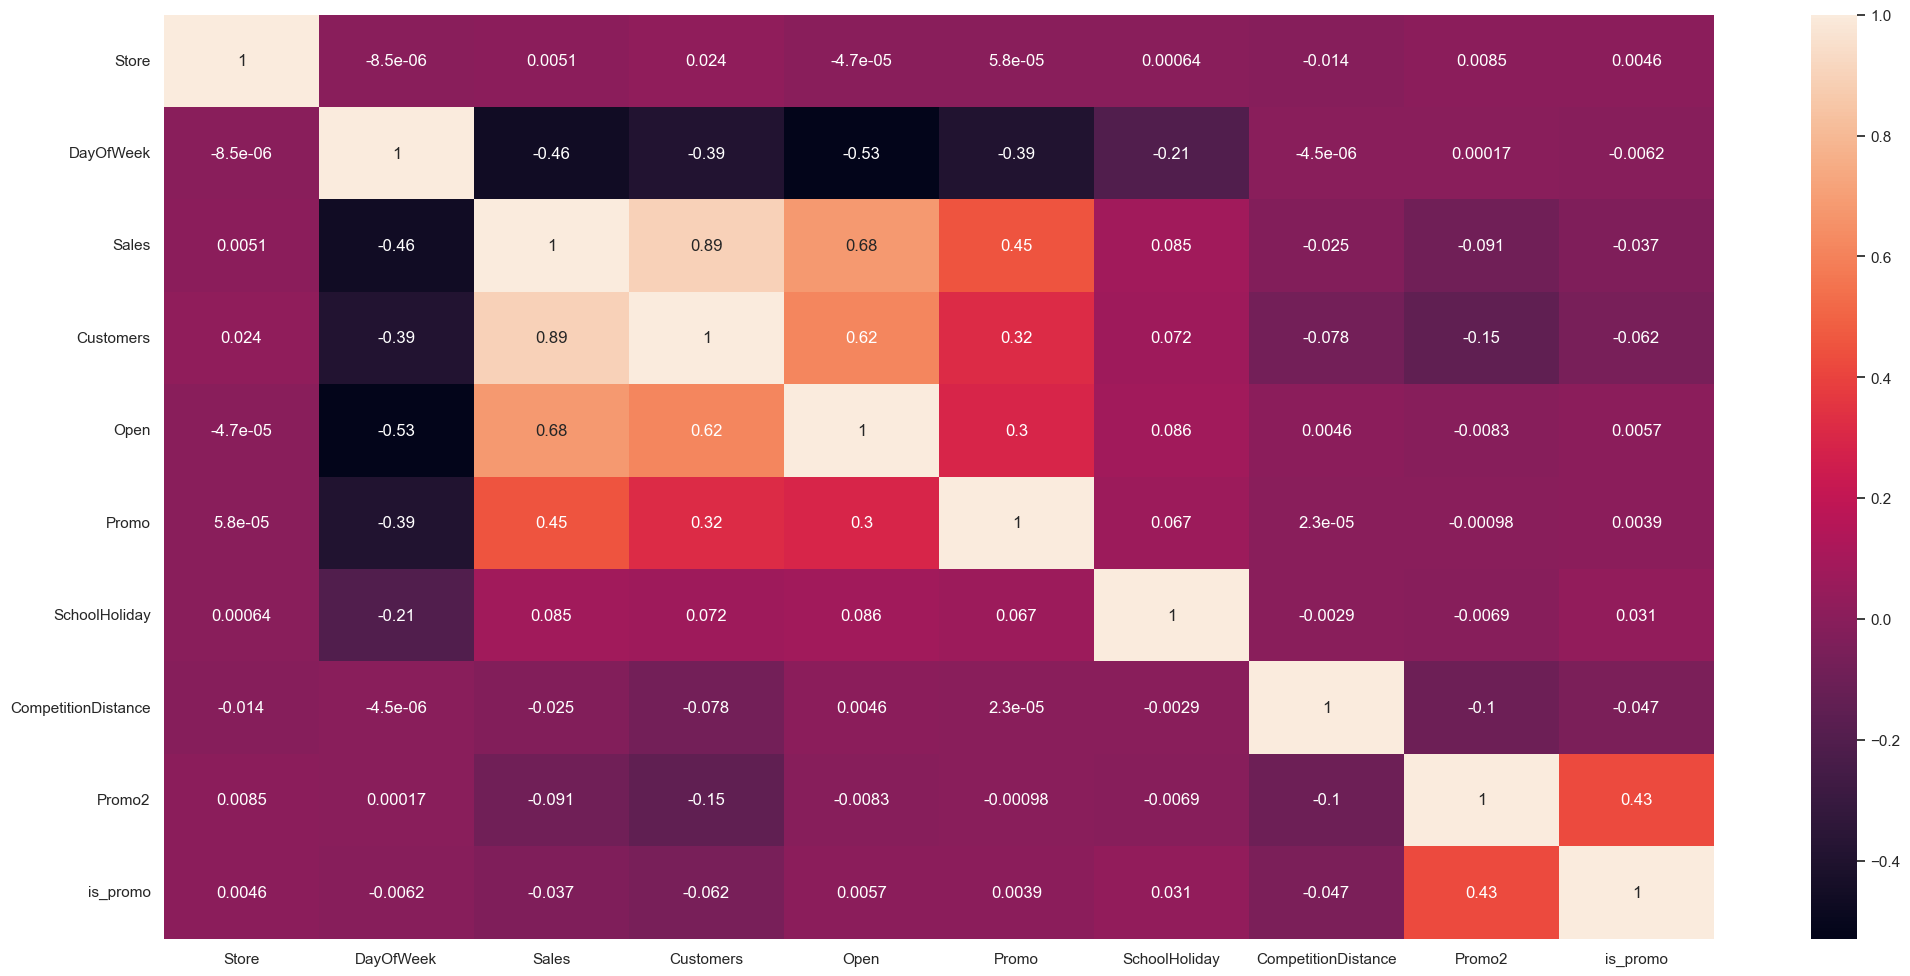

In [30]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2 Categorical Attributes

<AxesSubplot: >

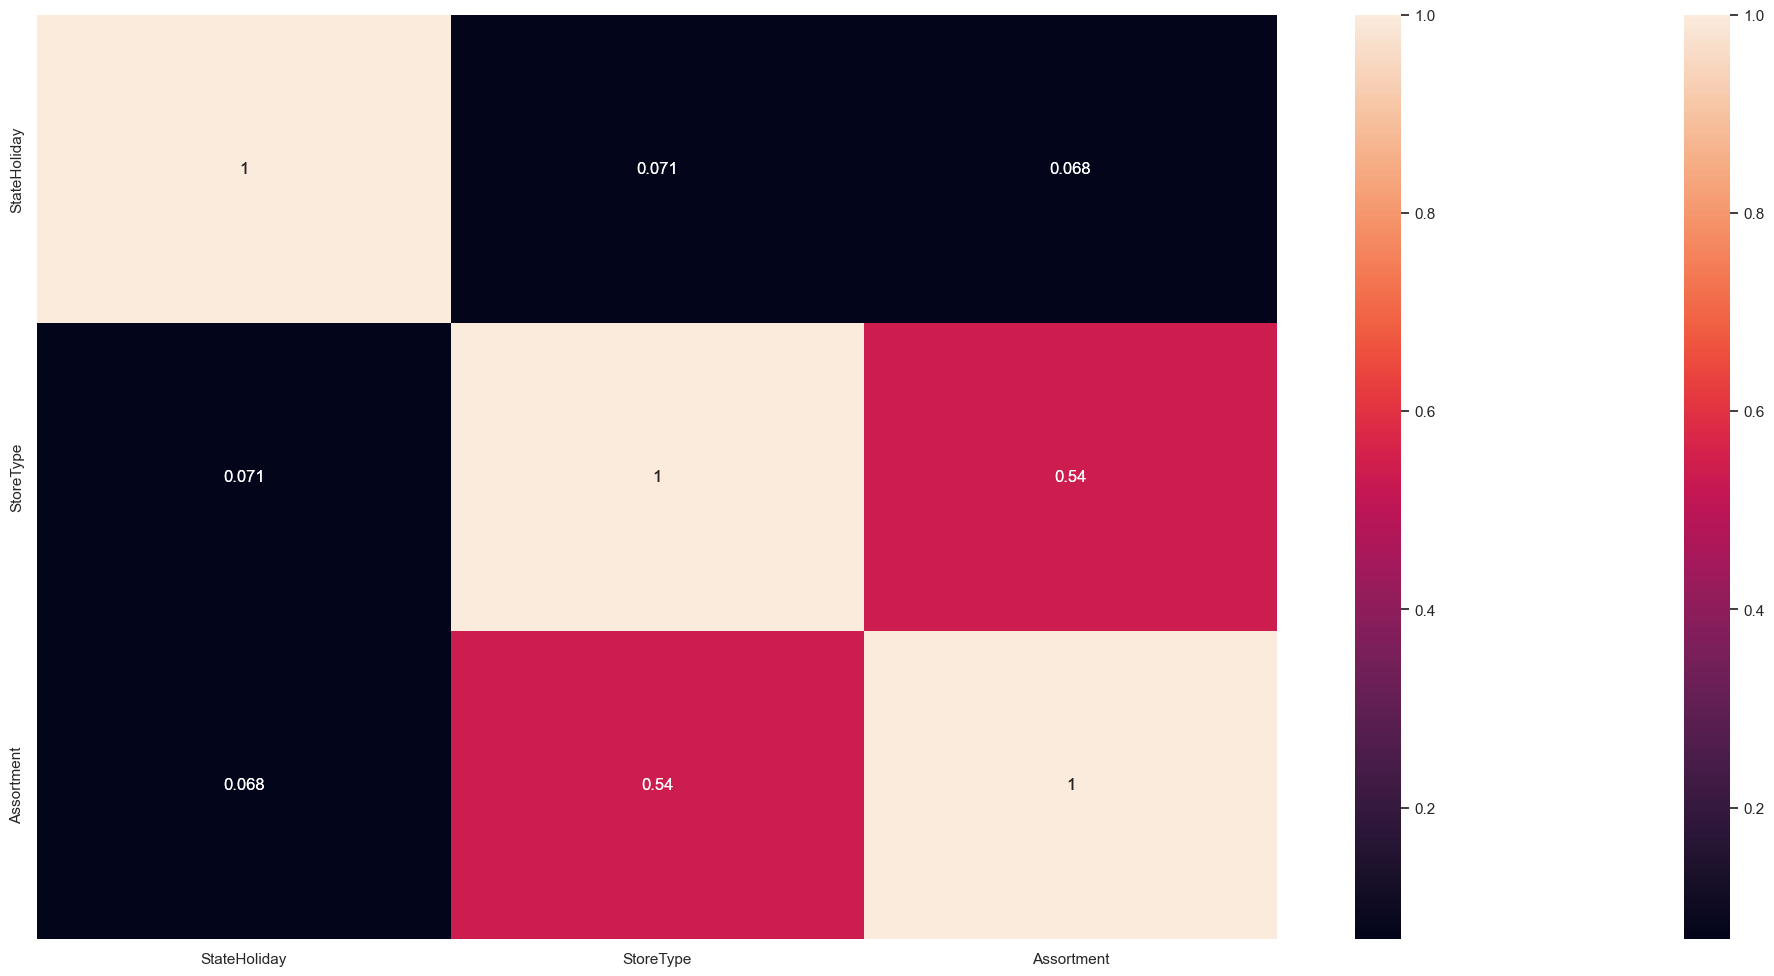

In [35]:
# Apenas para variáveis categóricas
# k é o numero de colunas e r é o numero de linhas)
a = df4.select_dtypes( include='object' )

# Criando a matriz de confusão
a1 = cramer_v( a['StateHoliday'], a['StateHoliday'])
a2 = cramer_v( a['StateHoliday'], a['StoreType'] )
a3 = cramer_v( a['StateHoliday'], a['Assortment'] )

a4 = cramer_v( a['StoreType'], a['StateHoliday'] )
a5 = cramer_v( a['StoreType'], a['StoreType'] )
a6 = cramer_v( a['StoreType'], a['Assortment'] )

a7 = cramer_v( a['Assortment'], a['StateHoliday'] )
a8 = cramer_v( a['Assortment'], a['StoreType'] )
a9 = cramer_v( a['Assortment'], a['Assortment'] )

# Final dataset
d = pd.DataFrame( {'StateHoliday': [a1, a2, a3], 
               'StoreType': [a4, a5, a6],
               'Assortment': [a7, a8, a9]  })
d = d.set_index( d.columns ) # todas as colunas e linhas com nomes iguais

# correlações entre variáveis categóricas
sns.heatmap( d, annot=True )


# only categorical data (Cramer V é usado para variáveis categóricas)
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['StateHoliday'], a['StateHoliday'] )
a2 = cramer_v( a['StateHoliday'], a['StoreType'] )
a3 = cramer_v( a['StateHoliday'], a['Assortment'] )

a4 = cramer_v( a['StoreType'], a['StateHoliday'] )
a5 = cramer_v( a['StoreType'], a['StoreType'] )
a6 = cramer_v( a['StoreType'], a['Assortment'] )

a7 = cramer_v( a['Assortment'], a['StateHoliday'] )
a8 = cramer_v( a['Assortment'], a['StoreType'] )
a9 = cramer_v( a['Assortment'], a['Assortment'] )

# Final dataset
d = pd.DataFrame( {'StateHoliday': [a1, a2, a3], 
               'StoreType': [a4, a5, a6],
               'Assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

In [ ]:
# Nota:
# v de Cramer vai de zero a 1, só tem correlação positiva
# v = np.sqrt((chi2/n)/(min(k-1, r-1)))
# v

## 5. DATA PREPARATION

In [36]:
df5 = df4.copy()


### 5.1 Normalização

### 5.2 Rescaling

In [ ]:
rs = RobustScaler()
mms = MinMaxScaler()

# Competition distance
df5['CompetitionDistance'] = rs.fit_transform(df5[['CompetitionDistance']].values)

# Competition time month
df5['CompettionTimeMonth'] = rs.fit_transform(df5[['CompettionTimeMonth']].values)

# Promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# Year
df5['year'] = mms.fit_transform(df5[['year']].values)

### 5.3 Transformação

### 5.3.1 Encoding

In [ ]:
# State Holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['StateHoliday'], columns=['StateHoliday']
                     
# Store type - Label encoding
le = LabelEncoder()
df5['StoreType'] = le.fit_transform(df5['StoreType'])
                     
# Assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['Assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [ ]:
df5['Sales'] = np.log1p(df5['Sales'])

### 5.3.4 Nature Transformation

In [37]:
# Day of week
df5['DayOfWeek_Sin'] = df5['DayOfWeek'].apply(lambda x: np.sin(x*(2. * np.pi/7)))
df5['DayOfWeek_Cos'] = df5['DayOfWeek'].apply(lambda x: np.cos(x*(2. *np.pi/7)))

# Month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2. *np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2. *np.pi/12)))

# Day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2. *np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2. *np.pi/30)))

# Week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2. *np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2. *np.pi/52)))

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'CompetitionSince',
       'CompettionTimeMonth', 'promo_since', 'promo_time_week'],
      dtype='object')

In [ ]:
df5.head()

In [ ]:
(a['state_holiday'] == 'christmas') & (a['store_type'] == 'a')]